# Машинное обучение, ФКН ВШЭ

## Практическое задание 2. Exploratory Data Analysis и линейная регрессия

### Общая информация
Дата выдачи: 26.09.2021

Мягкий дедлайн: 23:59MSK 11.10.2021

Жесткий дедлайн: 23:59MSK 14.10.2021

### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `seaborn` и `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. Сам ноутбук называйте в формате homework-practice-02-linregr-Username.ipynb, где Username — ваша фамилия.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

Оценка: xx.

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [1]:
!pip install folium

You should consider upgrading via the '/Users/katyona/anaconda3/bin/python -m pip install --upgrade pip' command.


In [2]:
import folium

m = folium.Map(location=(55.7522200, 37.6155600), zoom_start=10)

m

Если вы всё сделали правильно, то выше должна открыться карта Москвы.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")

## Часть 0. Подготовка (1 балл)

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [4]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df = pd.read_csv("nyc-taxi-trip-duration/train.csv")

Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [5]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df = df.drop(columns=['dropoff_datetime'])

In [6]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S.%f')

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

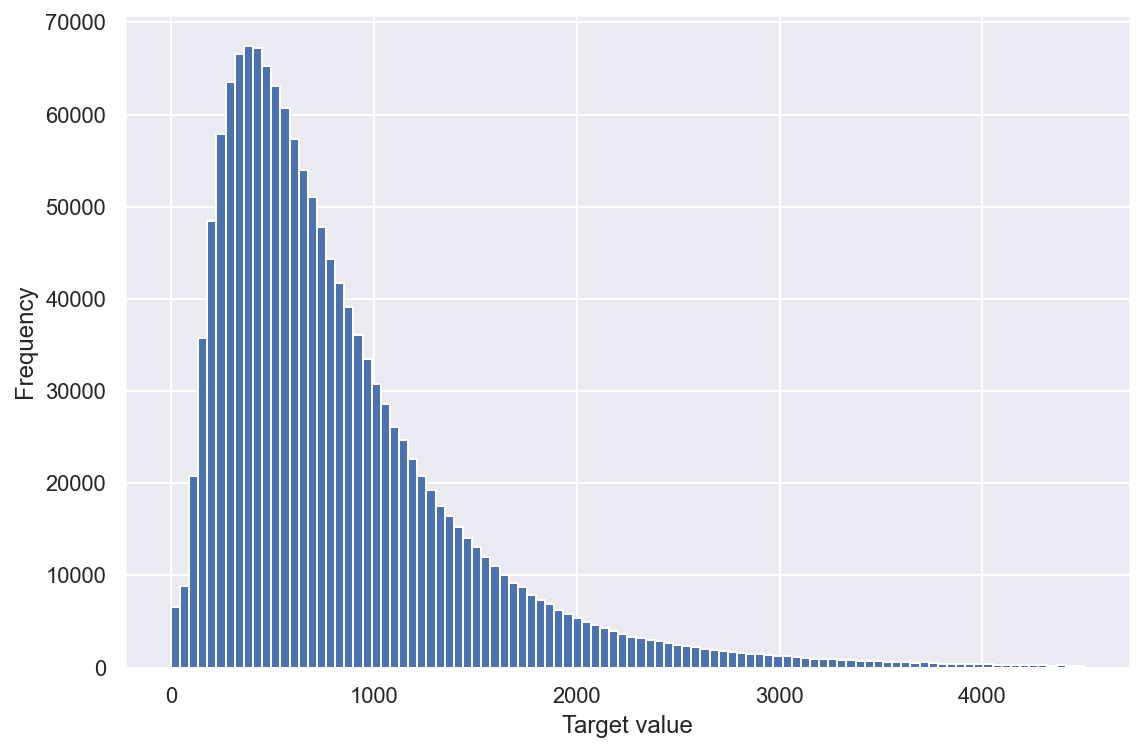

In [7]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 9, 6
plt.hist(list(df['trip_duration']), bins=100, range=(0, 4500))
plt.xlabel("Target value")
plt.ylabel("Frequency")
plt.show()

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

**Ответ:** она не имеет нормальное распределение. Большее число значений располагается в районе отметки 400 секунд, и чем короче поездки ниже этой длительности, тем реже они встречаются, и для каждого времени больше примерно 400 секунд поездки с такой длиной встречаются все реже и реже.

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

**Ответ:** 
* Во-первых, у нас в выборке достаточно часто встречаются большие значения целевой переменной и нам не очень сильно хотелось бы сильно штрафовать за большую разницу для больших значений, в отличие от такой же разницы при маленьких значениях (например, не так страшно спрогнозировать 4000 вместо 3000, как 2000 вместо 1000). 
* Во-вторых, в данной задаче недопрогноз страшнее перепрогноза, и данный функционал ошибки это учитывает, в отличие от RMSE (то есть в RMSE $(1500 - 1000)^2 = (1500 - 2000)^2$, а в RMSLE $(log(1500) - log(1000))^2 > (log(1500) - log(2000))^2$). 

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**: ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
* Для начала рассмотрим подготовку к оптимизации: все значения таргета ${y}_i$ меняются на $\hat{y}_i$, соответственно то же самое происходит с моделью, ведь мы не можем сравнивать предсказание изначальной целевой переменной с ее логарифмом. 
* Уточним, что выражение $a(x_i) = \exp(\hat{a}(x_i)) - 1$ вообще не участвует в оптимизации - оно нам нужно будет уже после получения модели, чтобы переделывать ее ответы в изначальную целевую переменную
* Тогда перепишем функционал ошибки и получим: $$\sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2} = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\hat{y}_i - \hat{a}(x_i)\big)^2}$$
* Теперь оптимизировать нужно будет выражение в правой половине уравнения, а по нему четко видно, что это RMSE.
* А оптимизиция RMSE эквивалентна оптимизации MSE, так как для этого достаточно просто выкинуть из формулы корень и потом надевать его на получившиеся значения. Экстремумы от этого не поменяются. (К слову, корень тут можно выкидывать из-за того, что подкоренное выражение априори не меньше нуля.)

Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

In [8]:
df['log_trip_duration'] = np.log1p(df['trip_duration'])

In [9]:
df = df.drop(columns=['trip_duration'])

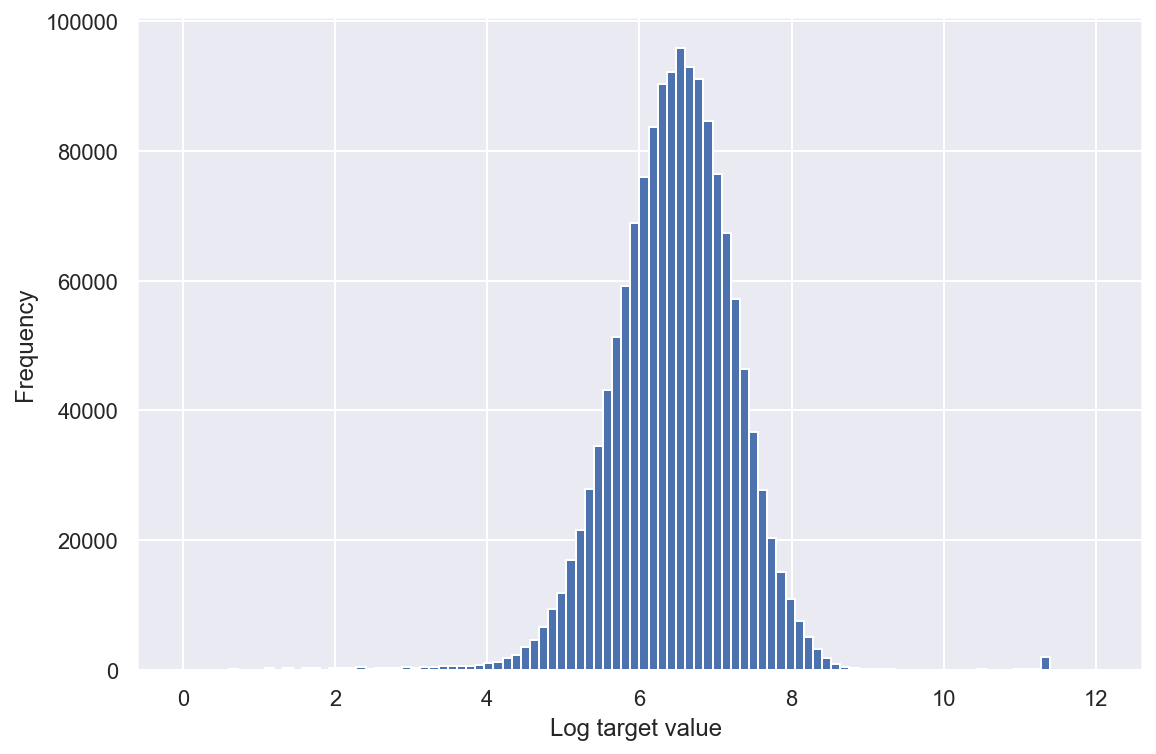

In [10]:
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 9, 6
plt.hist(list(df['log_trip_duration']), bins=100, range=(0, 12))
plt.xlabel("Log target value ")
plt.ylabel("Frequency")
plt.show()

Ура, теперь распределение похоже на нормальное

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

Наилучшее константное предсказание - это среднее.

In [11]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
a_const = np.mean(df['log_trip_duration'])

Полученное значение $RMSE$:

In [12]:
mse_const = np.sum(np.subtract(df['log_trip_duration'], a_const) ** 2) / df.shape[0]
mse_const ** 0.5

0.7957592365411504

## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

No handles with labels found to put in legend.


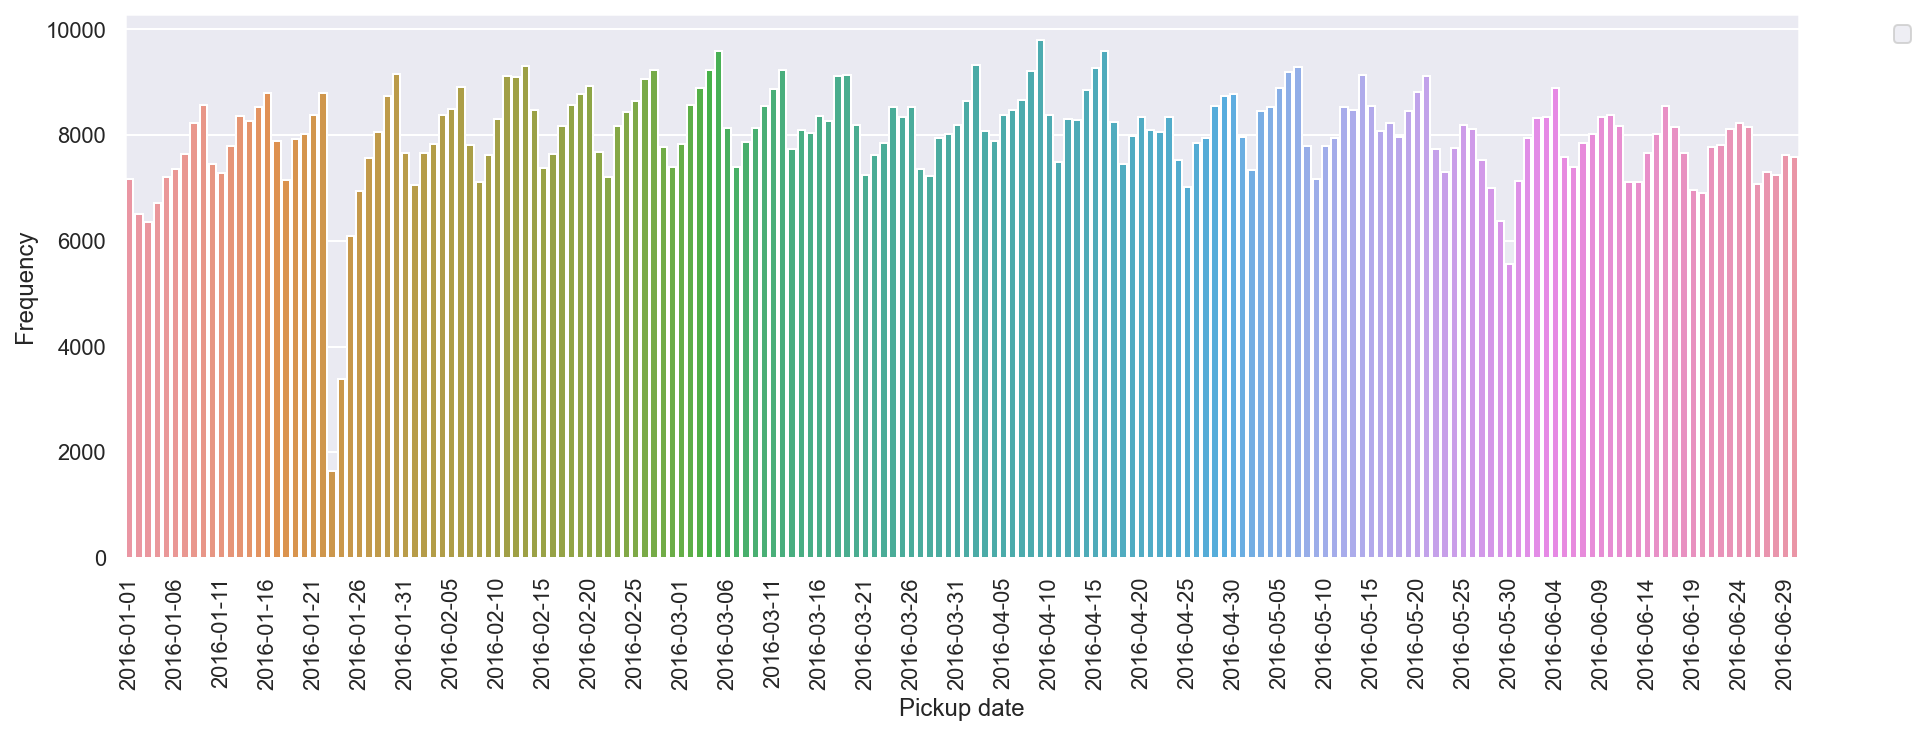

In [14]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df['pickup_date'] = df['pickup_datetime'].dt.date

%config InlineBackend.figure_format = 'retina'
plt.figure(figsize=(15, 5))
sns.countplot(x='pickup_date', data=df.sort_values(by=['pickup_date']))
ticks, labels = plt.xticks()
plt.xticks(ticks[::5], labels[::5], rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Pickup date")
plt.ylabel("Frequency")
plt.show()

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

In [15]:
df.groupby(['pickup_date']).size().nsmallest(4)

pickup_date
2016-01-23    1648
2016-01-24    3383
2016-05-30    5570
2016-01-25    6084
dtype: int64

**Ответ:** 
1. [Новостные источники](https://www.theguardian.com/us-news/live/2016/jan/23/blizzard-snowstorm-washington-new-york-east-coast) сообщают, что 23 января 2016 года на Нью-Йорк обрушился рекордный снегопад, 9 человек погибло в авариях, еще несколько - при откапывании города от снега, в связи с чем людям рекомендовалось не выходить на улицу, театры были временно закрыты, а также некоторые виды общественного транспорта перестали ходить и некоторые дороги были перекрыты! Конечно, это отразилось на поездках на такси 23, 24 и 25 января (хотя в последние 2 дня количество поездко постепенно росло). 
2. Второе аномально низкое количество поездок на такси датируется 30-м мая - это Memorial day - праздник, отмечающийся в последний понедельник мая. Из-за того, что это государственный праздник, он является выходным, это и объясняет снижение спроса на услуги такси.

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

In [16]:
# сначала добавим признаки в таблицу
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_weekday'] = df['pickup_datetime'].dt.dayofweek

Ниже изображен график зависимости количества поездок от дня недели:

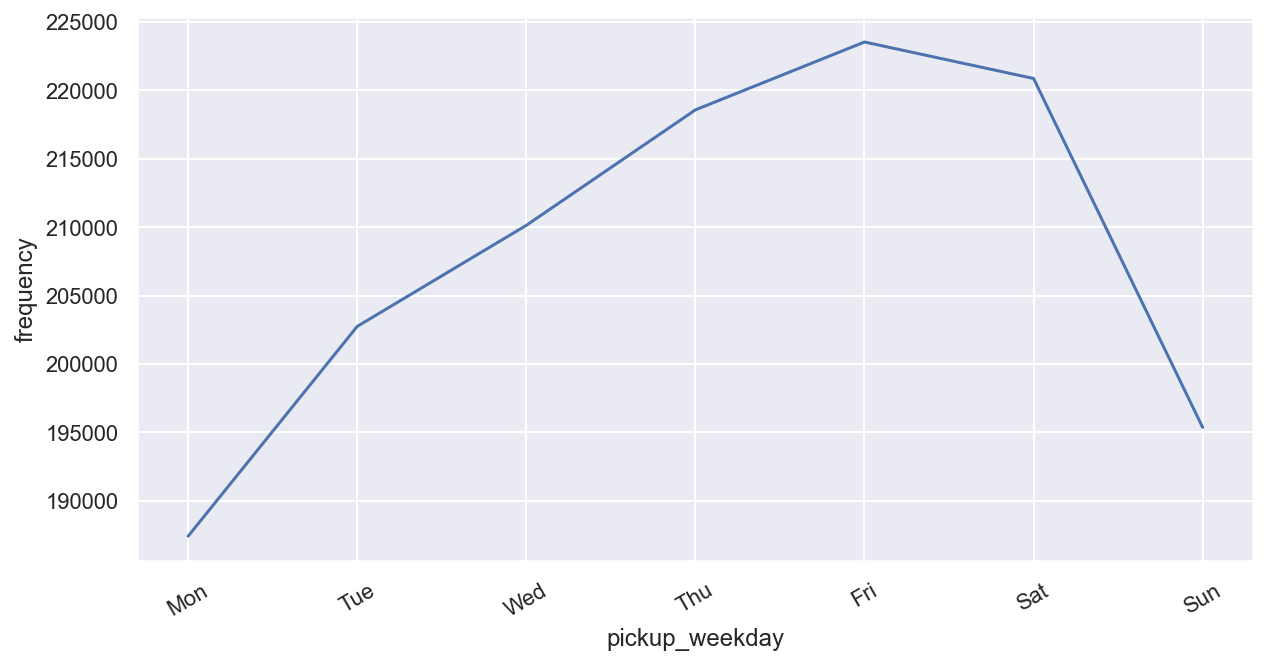

In [17]:
gb_weekday = pd.DataFrame(df.groupby(['pickup_weekday']).size()).reset_index()
gb_weekday = gb_weekday.rename(columns={0:'frequency'})
weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

%config InlineBackend.figure_format = 'retina'
# plot
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x='pickup_weekday', y='frequency', data=gb_weekday, ax=ax)
# set xticks position and labels
ax.set_xticks(range(0, 7))
ax.set_xticklabels(weekdays, rotation=30)
plt.rcParams['font.size'] = 12

Ниже график зависимости количества поездок на такси от времени суток:

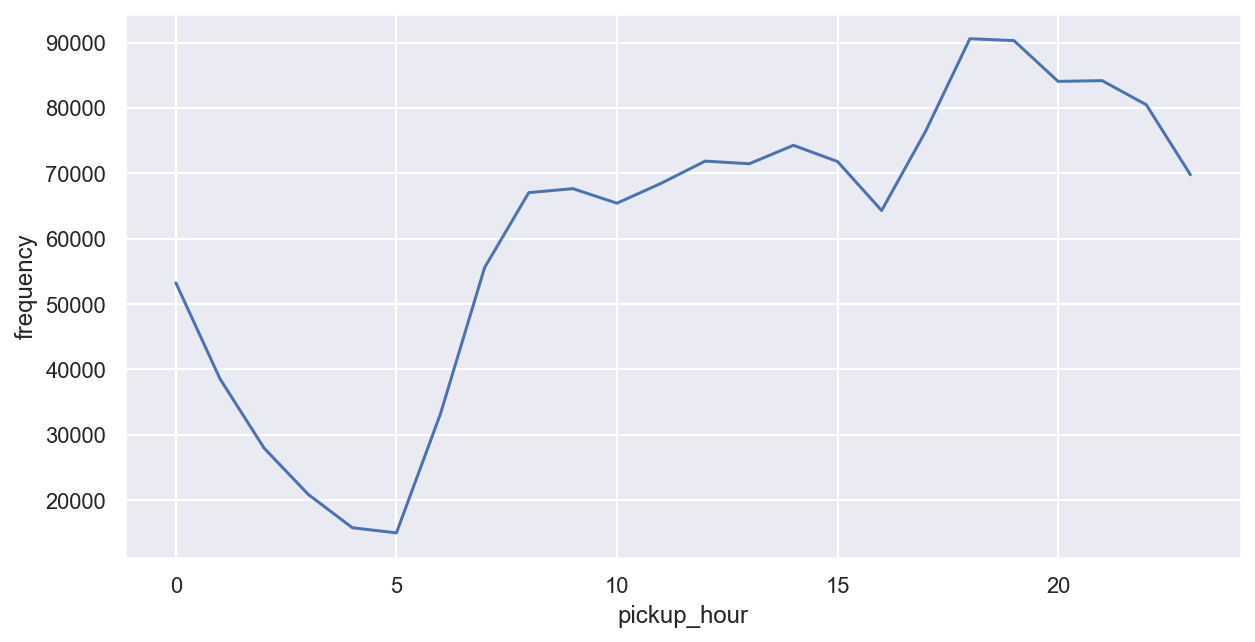

In [18]:
gb_hour = pd.DataFrame(df.groupby(['pickup_hour']).size()).reset_index()
gb_hour = gb_hour.rename(columns={0:'frequency'})

%config InlineBackend.figure_format = 'retina'
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x='pickup_hour', y='frequency', data=gb_hour, ax=ax)
plt.rcParams['font.size'] = 12

**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

Сначала добавим признак с месяцем в датафрейм, потом проведем группировку по месяцу и по часу (признак часа был добавлен в прошлом задании), а потом построим график

In [19]:
df['pickup_month'] = df['pickup_datetime'].dt.month

In [20]:
gb_month = pd.DataFrame(df.groupby(['pickup_month', 'pickup_hour']).size()).reset_index()
gb_month = gb_month.rename(columns={0:'frequency'})
months = ['-', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
gb_month['pickup_month'] = gb_month['pickup_month'].apply(lambda row: months[row])

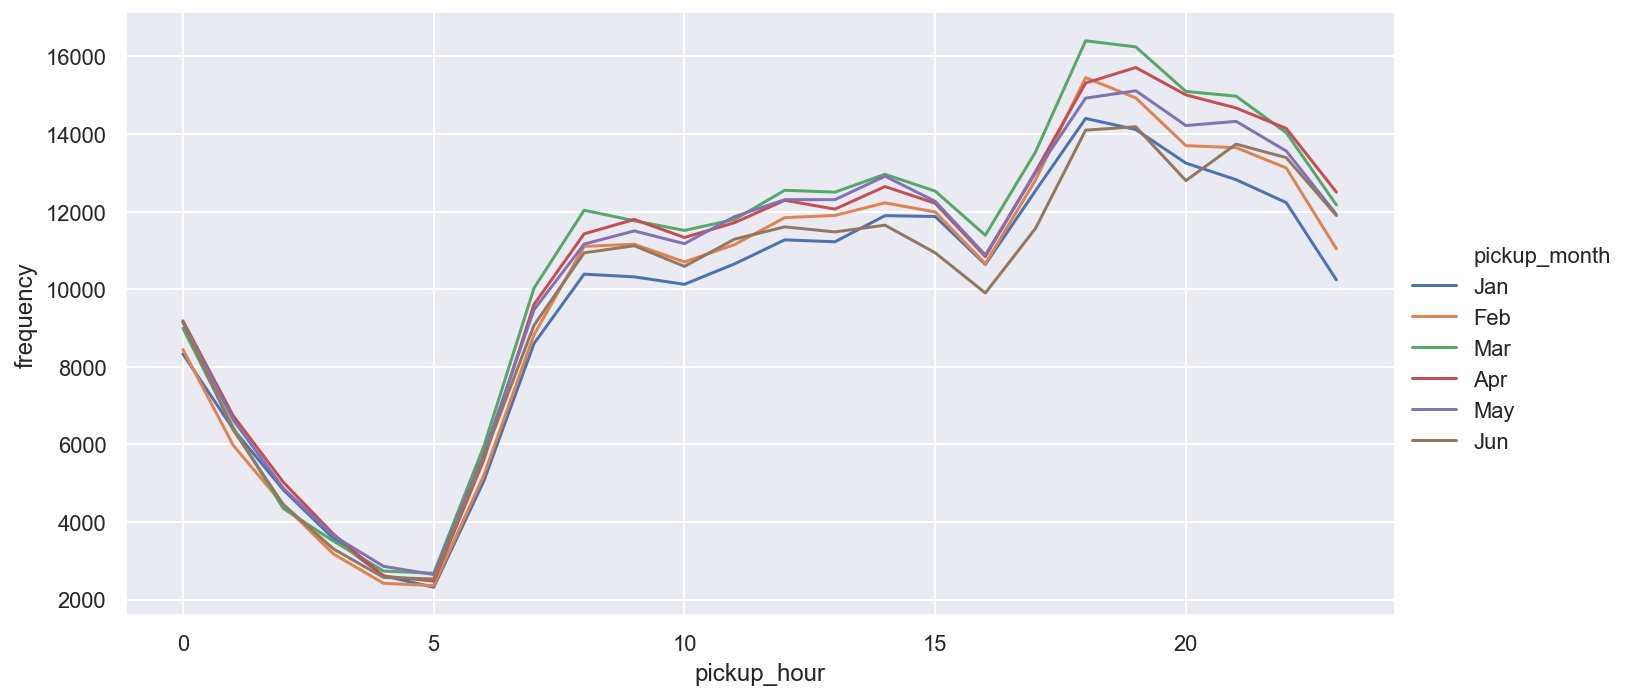

In [21]:
%config InlineBackend.figure_format = 'retina'
sns.relplot(x="pickup_hour", y='frequency', hue='pickup_month', 
               data=gb_month, kind="line", height=5, aspect=2,#col_wrap=3, 
               facet_kws={'sharey':False, 'sharex':False})
plt.rcParams['font.size'] = 12

То же самое: сначала сгруппируем по дню недели и по часу, а затем построим по получившимся данным график:

In [22]:
gb_hour_weekday = pd.DataFrame(df.groupby(['pickup_weekday', 'pickup_hour']).size()).reset_index()
gb_hour_weekday = gb_hour_weekday.rename(columns={0:'frequency'})
gb_hour_weekday['pickup_weekday'] = gb_hour_weekday['pickup_weekday'].apply(lambda row: weekdays[row])

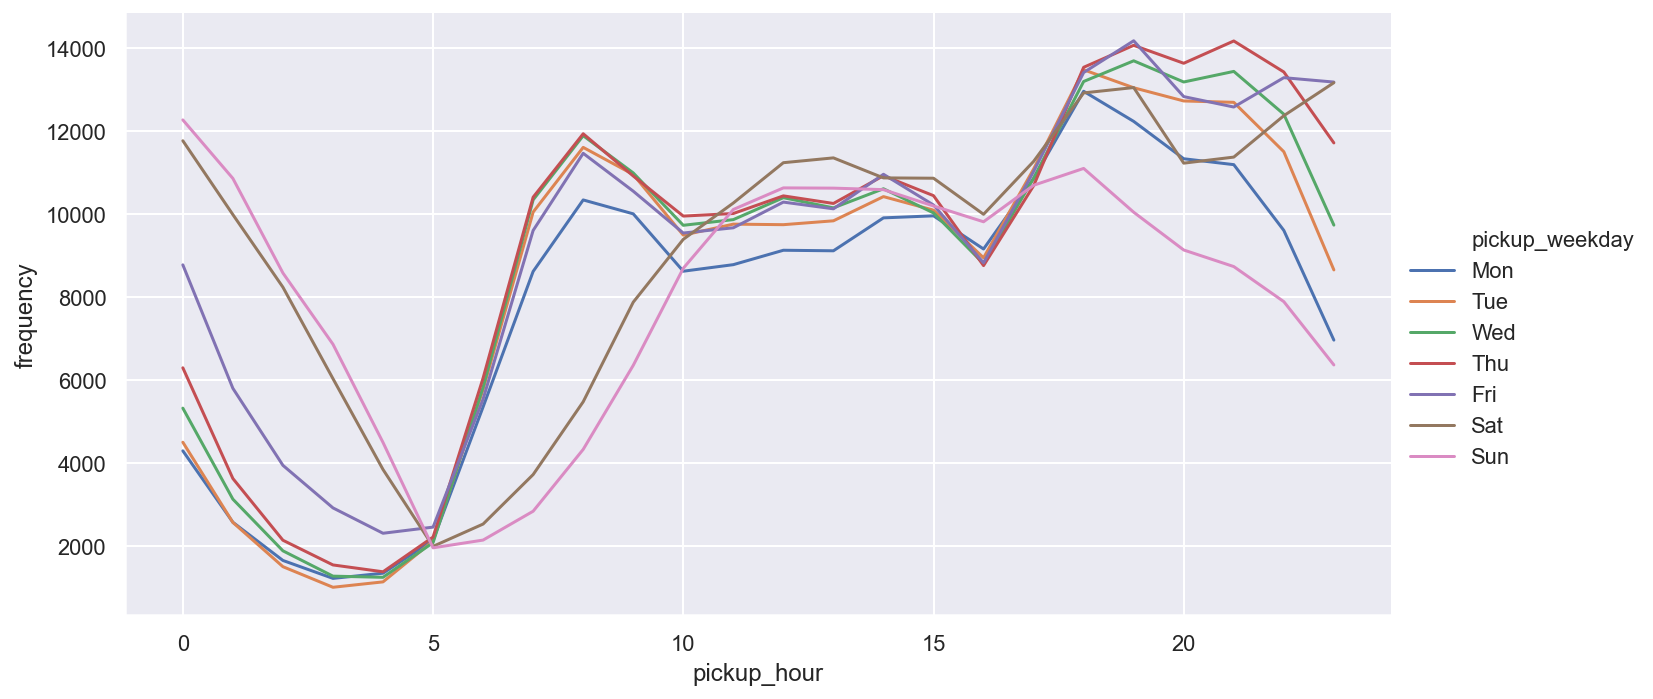

In [23]:
%config InlineBackend.figure_format = 'retina'
sns.relplot(x="pickup_hour", y='frequency', hue='pickup_weekday', 
               data=gb_hour_weekday, kind="line", height=5, aspect=2, 
               facet_kws={'sharey':False, 'sharex':False})
plt.rcParams['font.size'] = 12

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

**Ответ:**
* По *дням недели*: самое низкое количество поездок наблюдается в понедельник, затем в течение недели количество поездок постепенно растет и достигает максимума к пятнице, после чего снова начинает убывать.
* По *времени суток*: самое низкое количество поездок стабильно в районе 5 утра, что в целом логично; затем оно растет до 9-10 часов и остается примерно на том же уровне часов до 15-16, после чего резко растет и достигает максимума часам к 19-20, а затем снова снижается.
* По *месяцам и часам*: в принципе в каждом месяце распределение по часам примерно одинаковое. Оно практически совпадает в период с 0 примерно до 7 часов утра, после чего начинаются расхождения. В целом после этого часа наименьшее количество поездок происходит в январе и в июне, а наибольшее - в марте, и эта тенденция сохраняется практически все время с 0 до 23 часов.
* По *дням недели и часам*: тут совпадений по всем лням практически не наблюдается. По выходным активность с 0 до 5 часов значительно выше, чем в остальные дни, а вот в период с 5 до 10 утра - ниже. Еще в воскресенье количество поездок в вечернее время ниже, чем в остальные дни.

**Задание 4 (0.5 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3. По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

In [24]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3)

График зависимости среднего логарифма времени поездок от дня недели:

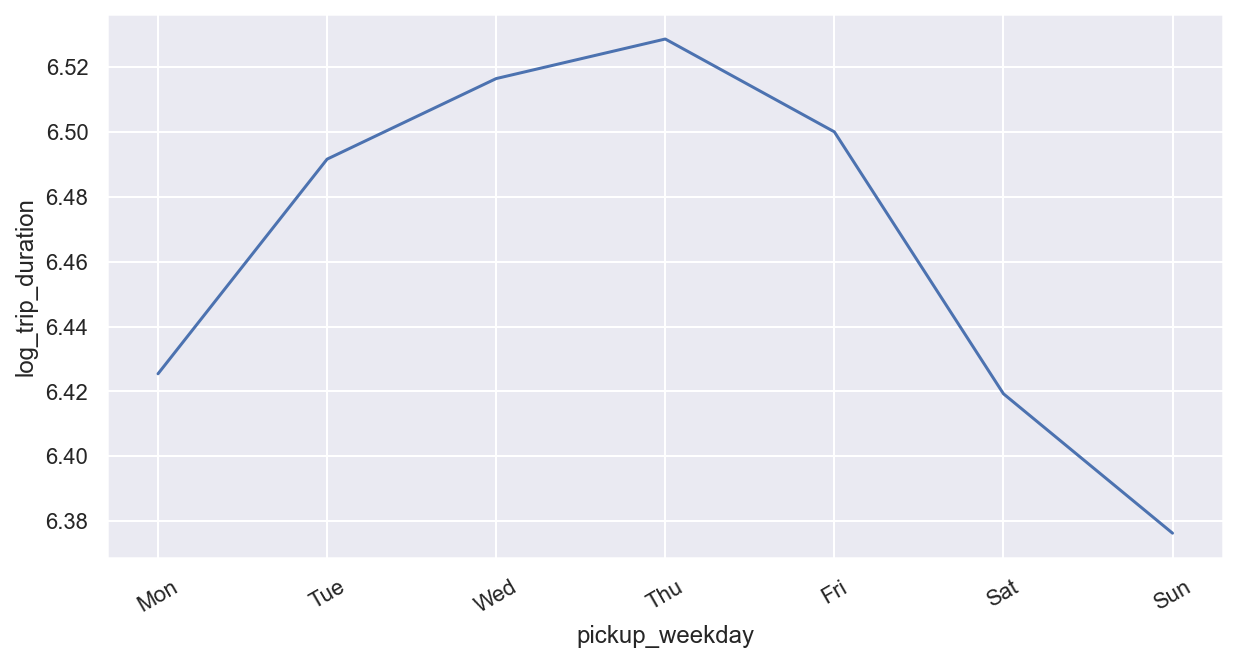

In [25]:
gblog_weekday = pd.DataFrame(train.groupby(['pickup_weekday'])['log_trip_duration'].mean()).reset_index()

%config InlineBackend.figure_format = 'retina'
# plot
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x='pickup_weekday', y='log_trip_duration', data=gblog_weekday, ax=ax)
# set xticks position and labels
ax.set_xticks(range(0, 7))
ax.set_xticklabels(weekdays, rotation=30)
plt.rcParams['font.size'] = 12

График зависимости логарифма длительности поездки от времени суток:

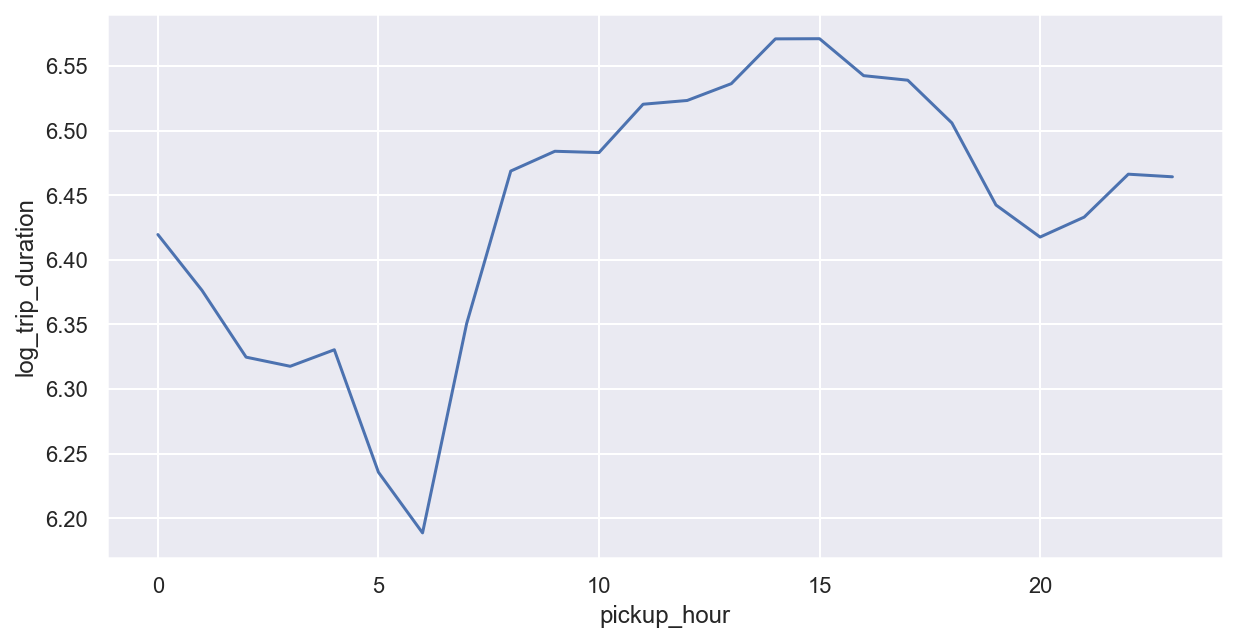

In [26]:
gblog_hour = pd.DataFrame(train.groupby(['pickup_hour'])['log_trip_duration'].mean()).reset_index()

%config InlineBackend.figure_format = 'retina'
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x='pickup_hour', y='log_trip_duration', data=gblog_hour, ax=ax)
plt.rcParams['font.size'] = 12

График зависимости логарифма длительности поездок от дня в году (то есть от даты, тк выборка у нас длиной меньше, чем в год):

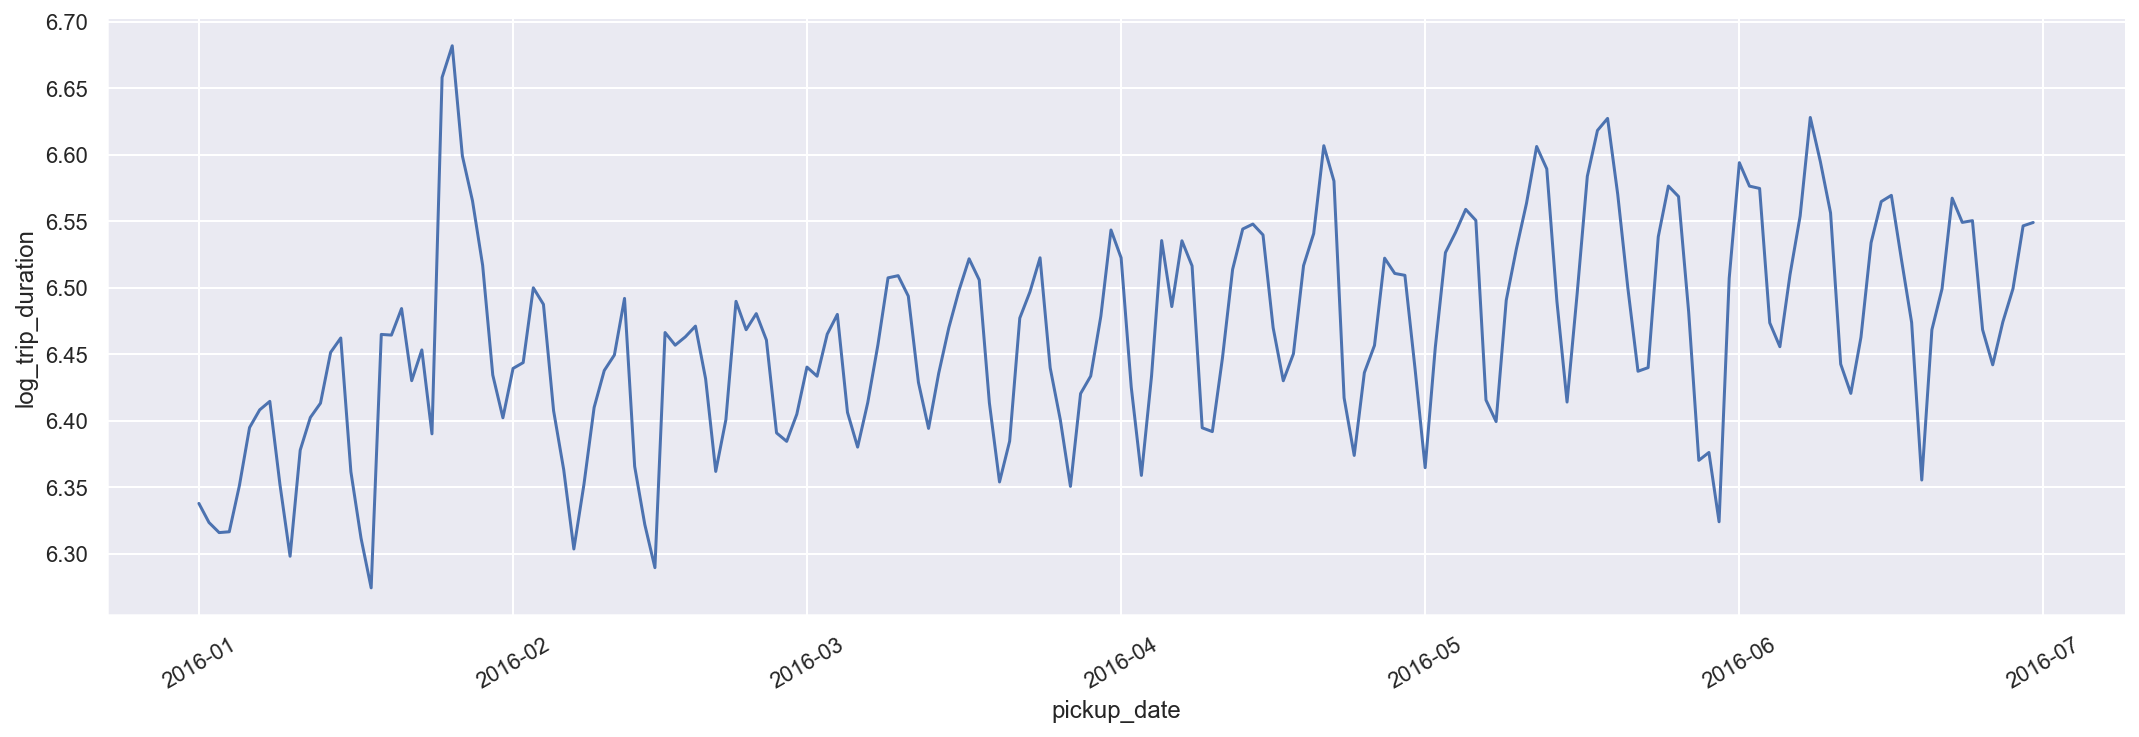

In [27]:
gblog_date = pd.DataFrame(train.groupby(['pickup_date'])['log_trip_duration'].mean()).reset_index()

%config InlineBackend.figure_format = 'retina'
sns.relplot(x="pickup_date", y='log_trip_duration', 
               data=gblog_date, height=5, aspect=3, kind="line",
               facet_kws={'sharey':False, 'sharex':False})
plt.rcParams['font.size'] = 12
ticks, labels = plt.xticks()
plt.xticks(ticks[::], labels[::], rotation=30)
plt.show()

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

**Ответ**:
* Графики зависимости от часа в сутках немного похожи. В период с 0 до 5 часов и длительность поездок, и их количество падают, но у графика длиетльности есть плато в районе 2-4 часов. С утра до дня и количество, и длительность поздок растут, но пик в длительности происходит раньше пика в частоте. В то время как к 20 часам длительность поездок достигает локального минимума и потом немного растет, частота поездок только-только начинает спадать с максимума.
* Графики зависимости от дня недели тоже несколько похожи, но будто со сдвигом. Частота поездок растет с понедельника по пятницу, после чего снижается, а вот длительность поездок растет с воскресенья по четверг и потом снижается. Это можно объяснить тем, что вместе с ростом числа поездок растет и их длительность из-за пробок, но все меняется в пятницу, когда люди чаще перемещаются на небольшие расстояния, например, между барами (то есть длительность резко падает, а вот количество наоборот продолжает расти).
* В первый аномальный период (23-24 января) таргет достигает своего максимума - из-за перекрытых дорог и аномальных снегопадов пропускная способность резко снизилась, что спровоцировало рост средней длительности поездки. Во второй аномальный период (30 мая) средняя длительность поездок опускается до весеннего минимума. Это можно связать с тем, что в праздник Memorial day жители Нью-Йорка не работают, а проводят время с семьей, из-за чего дороги свободные ивремя поездки сокращается.
* На графике зависимости среднего времени поездки от дня в году наблюдаются зависимости от дней недели, а также видно, что среднее время поездки при движении от зимы к весне растет (как в рабочие дни, так и в выходные). 

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [193]:
df['pickup_weekday'] = df['pickup_datetime'].dt.dayofweek
df['pickup_month'] = df['pickup_datetime'].dt.month
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_day_of_year'] = df['pickup_datetime'].dt.dayofyear

In [28]:
train['pickup_weekday'] = train['pickup_datetime'].dt.dayofweek
train['pickup_month'] = train['pickup_datetime'].dt.month
train['pickup_hour'] = train['pickup_datetime'].dt.hour
train['pickup_day_of_year'] = train['pickup_datetime'].dt.dayofyear

test['pickup_weekday'] = test['pickup_datetime'].dt.dayofweek
test['pickup_month'] = test['pickup_datetime'].dt.month
test['pickup_hour'] = test['pickup_datetime'].dt.hour
test['pickup_day_of_year'] = test['pickup_datetime'].dt.dayofyear

/Users/katyona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/katyona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/katyona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

In [29]:
def if_snow(row):
    return int(row == pd.to_datetime('2016-01-23') or row == pd.to_datetime('2016-01-24'))


def if_memorial_day(row):
    return int(row == pd.to_datetime('2016-05-30'))

In [31]:
vect_is_snow = np.vectorize(if_snow)
train['is_snow'] = vect_is_snow(train['pickup_date'])
test['is_snow'] = vect_is_snow(test['pickup_date'])

/Users/katyona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/katyona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [32]:
vect_is_mday = np.vectorize(if_memorial_day)
train['is_memorial_day'] = vect_is_mday(train['pickup_date'])
test['is_memorial_day'] = vect_is_mday(test['pickup_date'])

/Users/katyona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/katyona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков стоит рассматривать как категориальные, а какие - как численные? Почему?

**Ответ:** Все созданные только что признаки стоит сделать категориальными. Признаки, показывающие аномалии, вообще бинарные, а дней недели, месяцев, часов в сутках и дней в году ограниченное количество и они принимают только конечное число целочисленных значений.

**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [33]:
cat_columns = ['pickup_hour', 'pickup_weekday', 'pickup_month',
               'pickup_day_of_year']
binary_columns = ['is_snow', 'is_memorial_day']

In [34]:
X_train = pd.get_dummies(train[cat_columns], columns=cat_columns, prefix=cat_columns)
X_train = pd.concat([X_train, train[binary_columns]], axis=1)
y_train = train['log_trip_duration']

X_test = pd.get_dummies(test[cat_columns], columns=cat_columns, prefix=cat_columns)
X_test = pd.concat([X_test, test[binary_columns]], axis=1)
y_test = test['log_trip_duration']

In [37]:
from sklearn.linear_model import Ridge, Lasso

In [36]:
clf = Ridge()
clf.fit(X_train, y_train)

Ridge()

In [38]:
from sklearn.metrics import mean_squared_error
y_predict = clf.predict(X_test)
mean_squared_error(y_predict, y_test)

0.6195304863988942

## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [39]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [40]:
show_circles_on_map(df.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [41]:
show_circles_on_map(df.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

**Вопрос**: Какие две точки выделяются на карте?

**Ответ:** БОльшая часть поездок начинается и заканчивается в городе, однако на картах четко видно, что выделяются точки двух аэропортов: John F. Kennedy и LaGuardia.

**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [42]:
from sklearn.metrics.pairwise import haversine_distances
from math import radians

In [43]:
def haversine_distance(row):
    lat1, lon1, lat2, lon2 = row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude']
    r = 6371
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2)**2
    res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
    return np.round(res, 2)

In [44]:
train['haversine'] = train.apply(lambda row: haversine_distance(row), axis=1)
test['haversine'] = test.apply(lambda row: haversine_distance(row), axis=1)

/Users/katyona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/katyona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку:

In [45]:
train['log_haversine'] = np.log1p(train['haversine'])
test['log_haversine'] = np.log1p(test['haversine'])

/Users/katyona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/katyona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

In [46]:
train['log_trip_duration'].corr(train['haversine'])

0.5597293318009516

In [47]:
train['log_trip_duration'].corr(train['log_haversine'])

0.7496852787156362

**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

In [48]:
speed = (np.e**train['log_haversine'] - 1) / (np.e**train['log_trip_duration'] - 1) * 3600

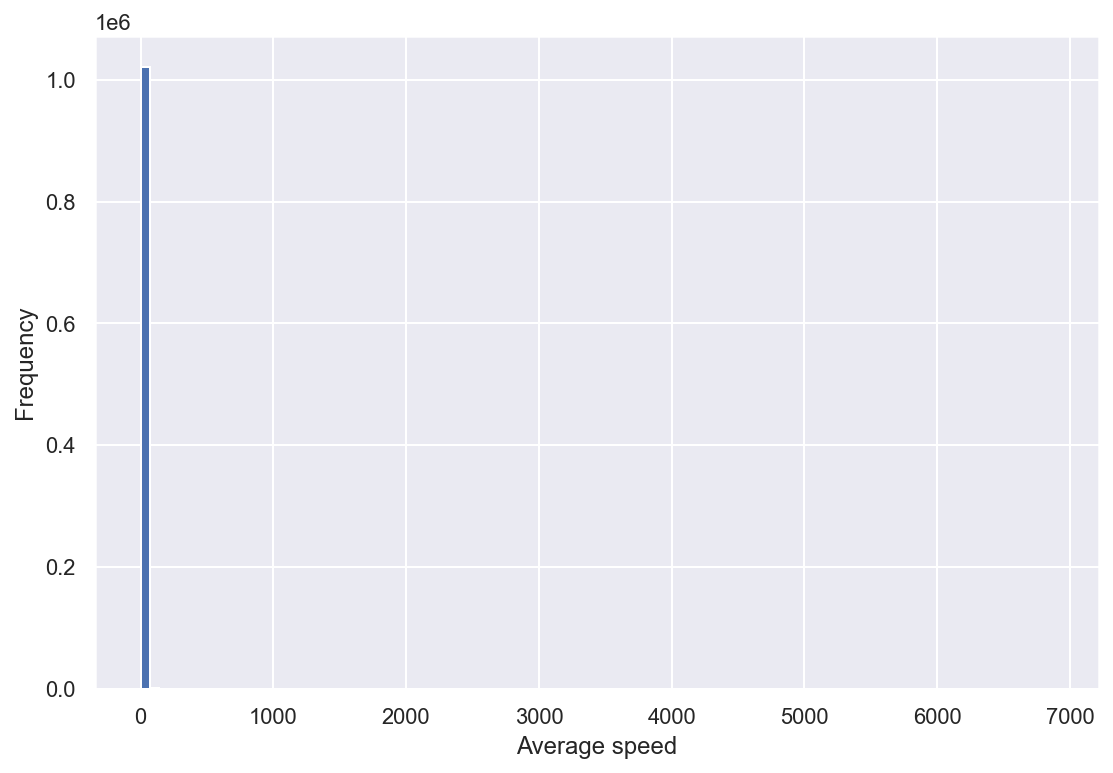

In [49]:
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 9, 6
plt.hist(speed, bins=100)
plt.xlabel("Average speed")
plt.ylabel("Frequency")
plt.show()

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

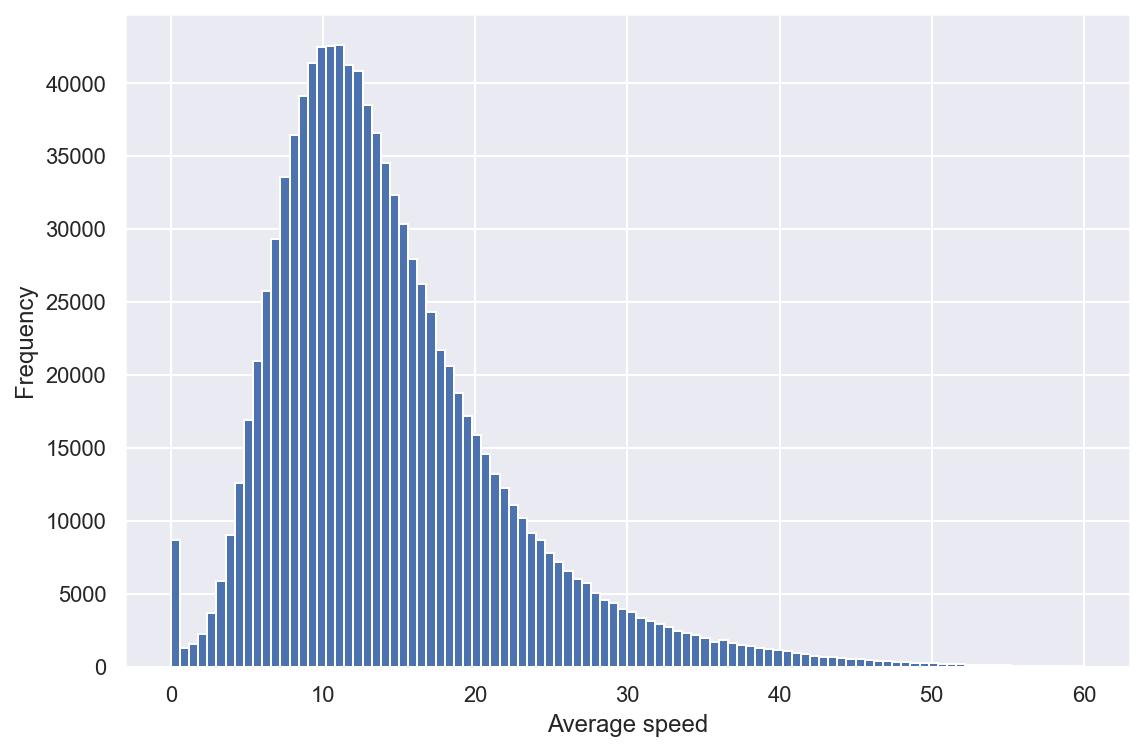

In [50]:
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 9, 6
plt.hist(speed, bins=100, range=(0, 60))
plt.xlabel("Average speed")
plt.ylabel("Frequency")
plt.show()

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

In [51]:
train['speed'] = train.apply(lambda row: (np.e**row['log_haversine'] - 1) / (np.e**row['log_trip_duration'] - 1) * 3600, axis=1)

/Users/katyona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


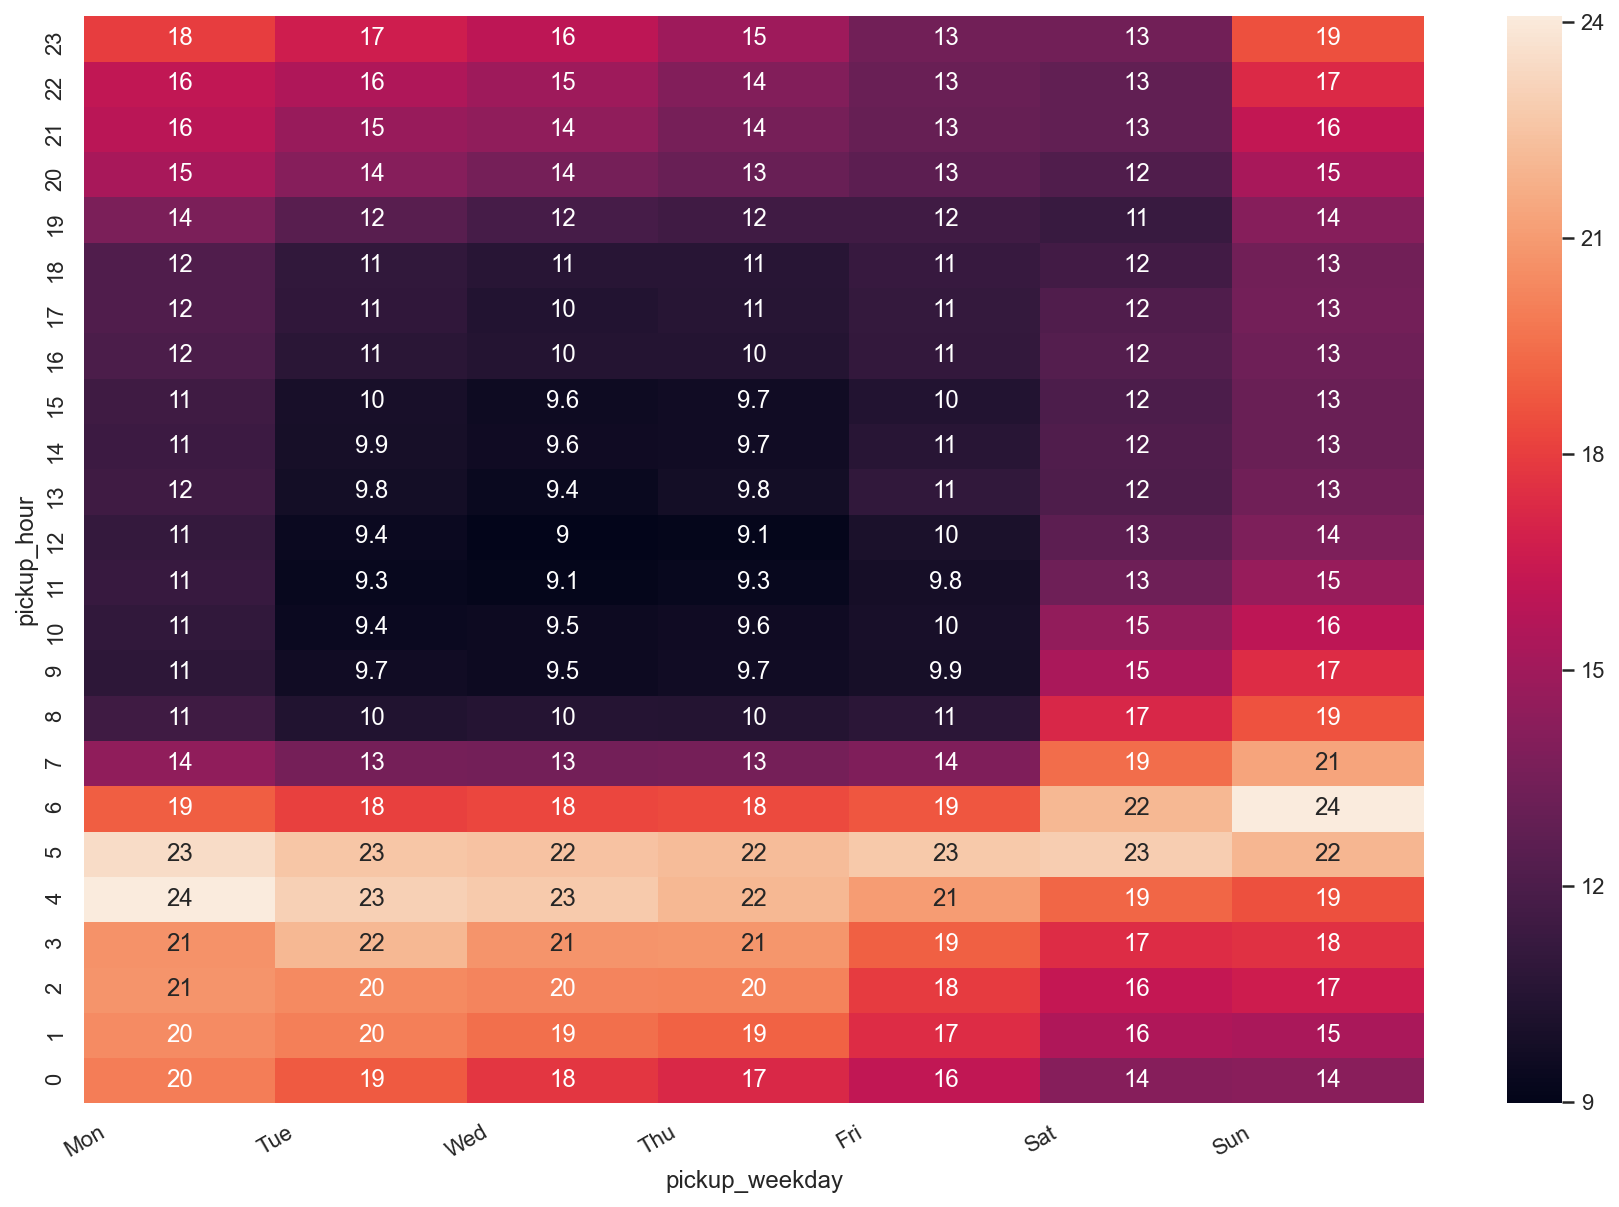

In [52]:
train_m = train.groupby(["pickup_weekday", "pickup_hour"])['speed'].median().unstack(level=0)

%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 15, 10
ax = sns.heatmap(train_m, annot=True)
ax.invert_yaxis()
ax.set_xticks(range(0, 7))
ax.set_xticklabels(weekdays, rotation=30)
plt.show()

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

**Ответ**: Скорость рассчитывалась с использованием таргета, а значит, во-первых, таргет зависит от нее напрямую, а во-вторых, нельзя будет посчитать скорость для тестовой выборки, у которой таргет в принципе еще не определен.

In [53]:
train = train.drop(columns=['speed'])

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

**Ответ**: Самое свободное время - понедельник в 4-5 утра и воскресенье в 6 утра. Наибольшая скорость наблюдается в среду в 12 часов дня.

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!): 

Яндекс утверждает, что пробками можно считать время, когда средняя скорость ниже 10 км/ч.

In [54]:
train_m = train_m.stack().reset_index().rename(columns={0:'speed'})

In [55]:
bad_traffic = train_m[train_m['speed'] < 10][['pickup_hour', 'pickup_weekday']]

In [56]:
def assign_bad_traffic(row):
    return int(row.values in bad_traffic.values)

In [57]:
train['is_rush_hour'] = train[['pickup_hour', 'pickup_weekday']].apply(assign_bad_traffic, axis=1)
test['is_rush_hour'] = test[['pickup_hour', 'pickup_weekday']].apply(assign_bad_traffic, axis=1)

/Users/katyona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


 Свободными же дорогами будем считать часы, в которые скорость средняя между средним и максимальным значением медианы:

In [58]:
median_3to4_max = (train_m['speed'].mean() + train_m['speed'].max()) / 2
good_traffic = train_m[train_m['speed'] > median_3to4_max][['pickup_hour', 'pickup_weekday']]

In [59]:
def assign_good_traffic(row):
    return int((good_traffic.values == row.values).all(1).any())

In [60]:
train['is_clear_roads'] = train[['pickup_hour', 'pickup_weekday']].apply(assign_good_traffic, axis=1)
test['is_clear_roads'] = test[['pickup_hour', 'pickup_weekday']].apply(assign_good_traffic, axis=1)

/Users/katyona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


**Задание 8 (0.25 балла)**. Как уже было замечено выше, на карте выделяются две точки вдали от Манхэттена. Для каждой из них добавьте в выборку два признака: началась ли поездка в ней и закончилась ли она в ней.

Будем считать, что поездка началась/закончилась в аэропорту, если координаты начала/конца поездки отличаются не более, чем на километр, от координат аэропорта. Это обусловлено тем, что аэропорты занимают большую площадь и посадка в такси может производиться только в ограниченном количестве мест, то есть поездка не может начаться в километре от аэропорта там, где не предусмотрена зона ожидания такси.

In [61]:
# returns if two objects are close to each other (distance is less than 1 km)
def is_close(lat1, lon1, lat2, lon2):
    r = 6371
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2)**2
    res = np.round(r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))), 2)
    return int(res <= 1)

is_close_vect = np.vectorize(is_close)

In [62]:
kennedy = [40.641766, -73.780968]
laguardia = [40.7769271, -73.87396590000003]

In [63]:
train['kennedy_pickup'] = is_close_vect(train['pickup_latitude'], train['pickup_longitude'], kennedy[0], kennedy[1])
train['kennedy_dropoff'] = is_close_vect(train['dropoff_latitude'], train['dropoff_longitude'], kennedy[0], kennedy[1])

train['laguardia_pickup'] = is_close_vect(train['pickup_latitude'], train['pickup_longitude'], laguardia[0], laguardia[1])
train['laguardia_dropoff'] = is_close_vect(train['dropoff_latitude'], train['dropoff_longitude'], laguardia[0], laguardia[1])

In [64]:
test['kennedy_pickup'] = is_close_vect(test['pickup_latitude'], test['pickup_longitude'], kennedy[0], kennedy[1])
test['kennedy_dropoff'] = is_close_vect(test['dropoff_latitude'], test['dropoff_longitude'], kennedy[0], kennedy[1])

test['laguardia_pickup'] = is_close_vect(test['pickup_latitude'], test['pickup_longitude'], laguardia[0], laguardia[1])
test['laguardia_dropoff'] = is_close_vect(test['dropoff_latitude'], test['dropoff_longitude'], laguardia[0], laguardia[1])

/Users/katyona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/katyona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/katyona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

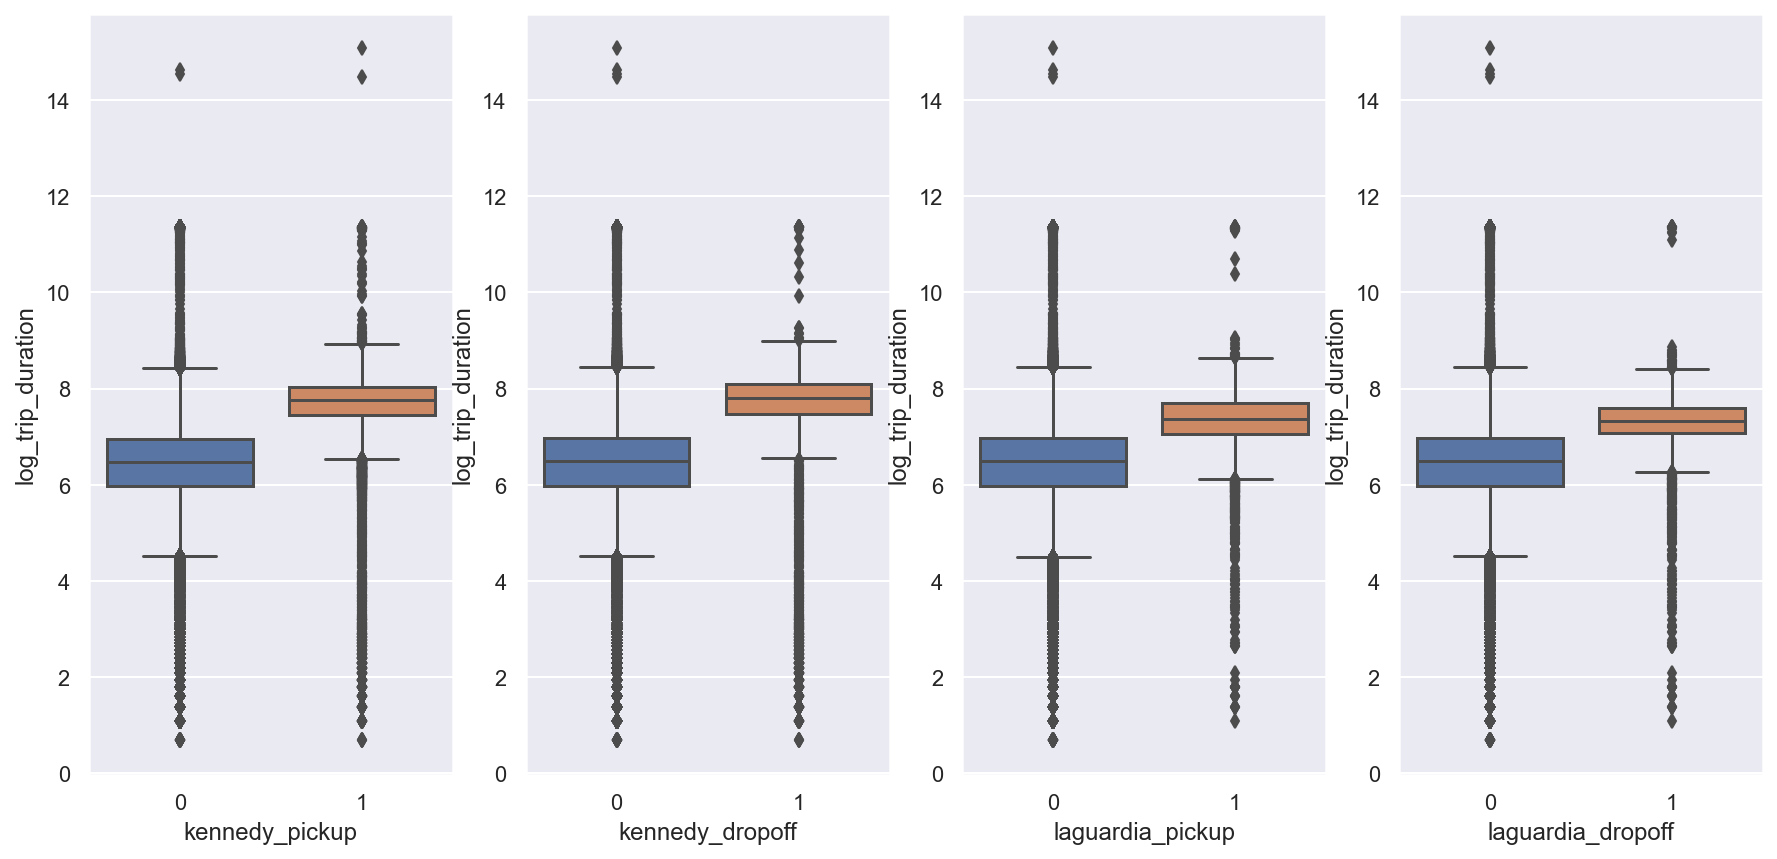

In [67]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 15, 7
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
sns.boxplot(x="kennedy_pickup", y="log_trip_duration", data=train, ax=ax1)
sns.boxplot(x="kennedy_dropoff", y="log_trip_duration", data=train, ax=ax2)
sns.boxplot(x="laguardia_pickup", y="log_trip_duration", data=train, ax=ax3)
sns.boxplot(x="laguardia_dropoff", y="log_trip_duration", data=train, ax=ax4)
plt.show()

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

**Ответ**: судя по графикам, признаки получились хорошие, тк в среднем поездки из аэропорта до города действительно длиннее, чем поездки по городу (ведь чтобы доехать до аэропорта, надо сначала проехать по городу, а потом выехать из него уехать на достаточно дальнее расстояние), но при этом разброс длительности у них поменьше (что тоже логично, тк за городом с пробками все проще, чем в городе).

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9 (1 балл)**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [68]:
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.spatial.distance import cdist

# открытый источник с кодом указан в конце работы
COL_NAMES = dict(
    pick_lat="pickup_latitude",
    pick_lon="pickup_longitude",
    drop_lat="dropoff_latitude",
    drop_lon="dropoff_longitude")

class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, loc, col, row, col_names=COL_NAMES):
        # координаты углов рассматриваемой области
        self.location_mh = loc
        # количество колонок в прямоугольной области
        self.col = col
        # количество рядов в прямоугольной области
        self.row = row
        # названия колонок, участвующие в рассмотрении
        self.col_names = col_names
        self.pick_lat = col_names["pick_lat"]
        self.pick_lon = col_names["pick_lon"]
        self.drop_lat = col_names["drop_lat"]
        self.drop_lon = col_names["drop_lon"]
        # углы прямоугольника: каждый добавлен в свою переменную
        self.lat_min, self.lat_max = loc[:, 0].min(), loc[:, 0].max()
        self.lon_min, self.lon_max = loc[:, 1].min(), loc[:, 1].max()


    def _fit(self):
        # тут списком задаются высоты и ширины каждого из секторов прямоугольной области
        self.walls = [(self.lat_max - self.lat_min) / self.col, \
              (self.lon_max - self.lon_min) / self.row]
        # координаты центров каждого сектора в прямоугольной области
        self.circles_loc = np.array([(((self.lat_min + i * (self.walls[0] / 2))), \
                               (self.lon_min + j * (self.walls[1] / 2)) ) \
                            for i in range(1, (self.col) * 2, 2) for j in range(1, (self.row) * 2, 2)])

        return self.walls, self.circles_loc


    def get_sector_idx(self, X):
        # здесь для каждой пары координат получаем индекс ее области
        pickup_idx = cdist(X.loc[:, [self.pick_lat, self.pick_lon]],
                           self.circles_loc).argmin(axis=1)
        dropoff_idx = cdist(X.loc[:, [self.drop_lat, self.drop_lon]],
                            self.circles_loc).argmin(axis=1)
        qry = f"@self.lat_min <= {self.pick_lat} <= @self.lat_max \
               and @self.lon_min <= {self.pick_lon} <= @self.lon_max"
        pickup_valid = X.eval(qry).to_numpy()
        pickup_idx[~pickup_valid] = -1
        qry = f"@self.lat_min <= {self.drop_lat} <= @self.lat_max \
               and @self.lon_min <= {self.drop_lon} <= @self.lon_max"
        dropoff_valid = X.eval(qry).to_numpy()
        dropoff_idx[~dropoff_valid] = -1
        return pickup_idx, dropoff_idx

    def transform(self, X):
        return self.get_sector_idx(X)


# список с координатами углов прямойгольника, указанного на карте
mh = np.array([
    [40.703314, -74.018608],
    [40.703314, -73.934241],
    [40.791438, -73.934241],
    [40.791438, -74.018608]
    ])

Теперь создаем элемент класса, на вход подаем координаты углов прямоугольника, количество столбцов и количество строк в желаемой сетке:

In [69]:
a = MapGridTransformer(mh, 3, 4)

In [71]:
a._fit()
train['pickup_area'], train['dropoff_area'] = a.transform(train)[0], a.transform(train)[1]
test['pickup_area'], test['dropoff_area'] = a.transform(test)[0], a.transform(test)[1]

/Users/katyona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

Признаки к данному моменту:
* `pickup_hour`
* `pickup_weekday`
* `pickup_month`
* `pickup_day_of_year`
* `is_snow`
* `is_memorial_day`
* `log_haversine`
* `is_rush_hour`
* `is_clear_roads`
* `kennedy_pickup`
* `kennedy_dropoff`
* `laguardia_pickup`
* `laguardia_dropoff`
* `pickup_area`
* `dropoff_area`

In [72]:
cat_columns = ['pickup_hour', 'pickup_weekday', 'pickup_month', 'pickup_day_of_year',  
               'pickup_area', 'dropoff_area']
binary_columns = ['is_snow', 'is_memorial_day', 'is_rush_hour', 'is_clear_roads', 
                  'kennedy_pickup', 'kennedy_dropoff', 
                  'laguardia_pickup', 'laguardia_dropoff',]

In [73]:
X_train = pd.get_dummies(train[cat_columns], columns=cat_columns, prefix=cat_columns)
X_train = pd.concat([X_train, train['log_haversine'], train[binary_columns]], axis=1)

X_test = pd.get_dummies(test[cat_columns], columns=cat_columns, prefix=cat_columns)
X_test = pd.concat([X_test, test['log_haversine'], test[binary_columns]], axis=1)

Чтобы не переобучиться, отмасштабируем отдельно `log_haversine` в тренировочной и тестовой выборках, тк масштабирование зависит от среднего по выборке

In [74]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train['log_haversine'] = scaler.fit_transform(np.array(X_train['log_haversine']).reshape(-1, 1))
scaler2 = StandardScaler()
X_test['log_haversine'] = scaler2.fit_transform(np.array(X_test['log_haversine']).reshape(-1, 1))

In [75]:
clf = Ridge()
clf.fit(X_train, y_train)

Ridge()

In [76]:
from sklearn.metrics import mean_squared_error
y_predict = clf.predict(X_test)
mean_squared_error(y_predict, y_test)

0.2270122239882413

После добавления признаков результат стал значительно лучше

## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

**Ответ**:
1. Вендоры могут работать в разных частях города, это может влиять на время. Может, в среднем поездки у одного длиннее, чем у другого, это тоже может влиять.
2. От количества пассажиров тоже может зависеть время. К примеру, 1 пассажир чаще добирается от дома до работы, в то время как 4 человека могут перемещаться на такси между барами или ехать в аэропорт, но вряд ли на работу. Еще большое количество пассажиров может высаживаться в разных местах, это тоже влияет на время.
3. Третий признак может быть полезным в случаях с местами далеко от центра, где нет сети или еще каки-то проблемы, что у такси не было подключения к серверу

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [77]:
print(f"vendor_id: {len(set(train['vendor_id'].values))} unique values")
print(f"passenger_count: {len(set(train['passenger_count'].values))} unique values")
print(f"store_and_fwd_flag: {len(set(train['store_and_fwd_flag'].values))} unique values")

vendor_id: 2 unique values
passenger_count: 8 unique values
store_and_fwd_flag: 2 unique values


Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

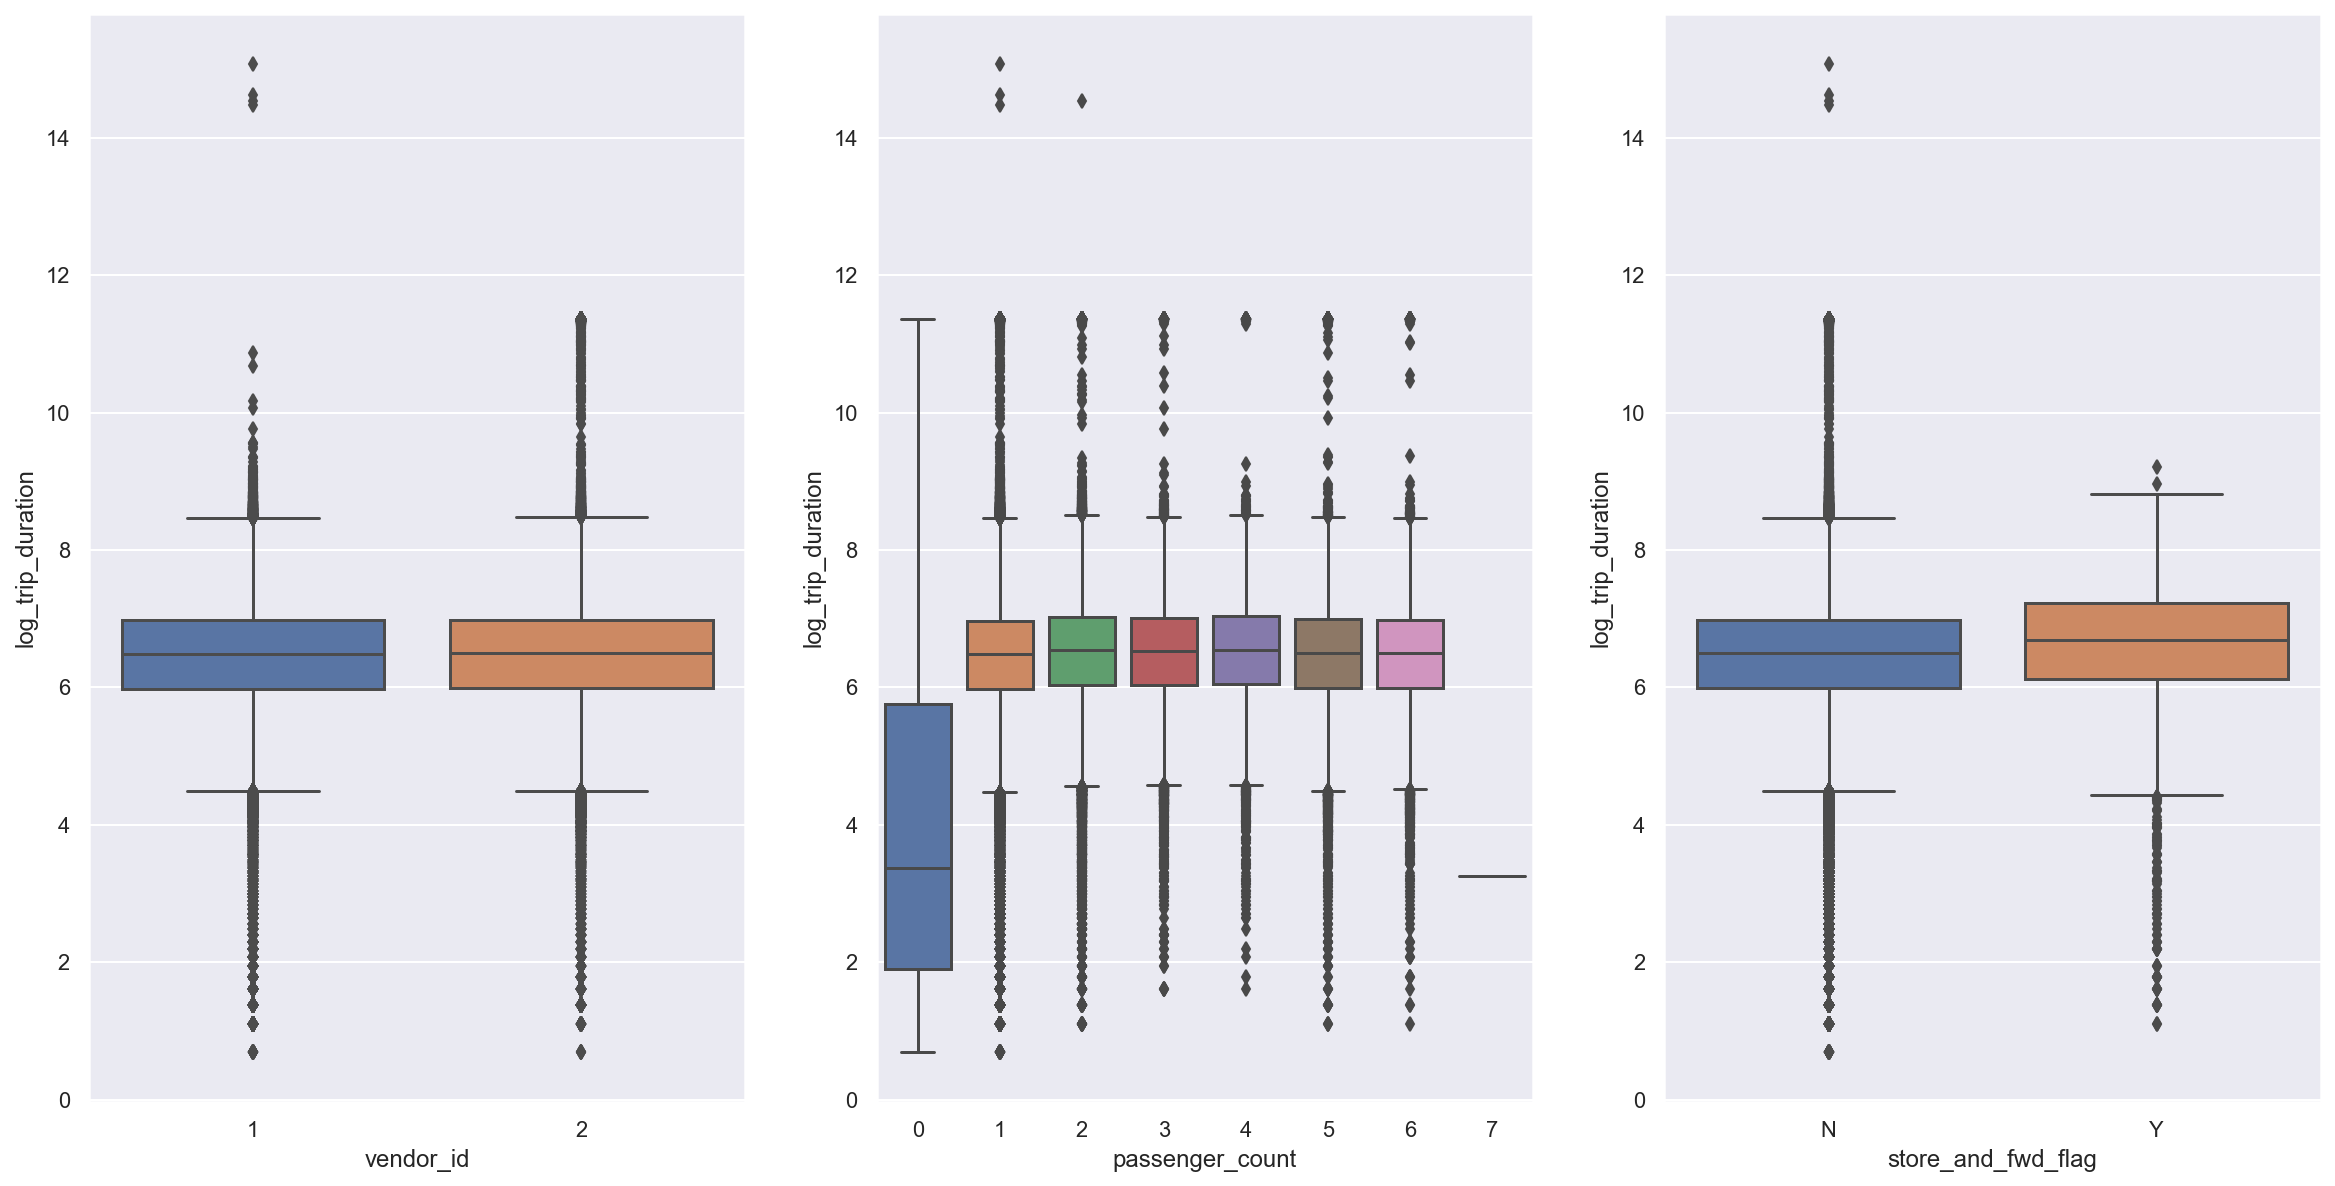

In [78]:
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 20, 10
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
sns.boxplot(x="vendor_id", y="log_trip_duration", data=train, ax=ax1)
sns.boxplot(x="passenger_count", y="log_trip_duration", data=train, ax=ax2)
sns.boxplot(x="store_and_fwd_flag", y="log_trip_duration", data=train, ax=ax3)
plt.show()

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [79]:
train['vendor_id'] = train['vendor_id'].apply(lambda row: row - 1)
test['vendor_id'] = test['vendor_id'].apply(lambda row: row - 1)

/Users/katyona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [81]:
train['store_and_fwd_flag'] = train['store_and_fwd_flag'].apply(lambda row: 1 if row=='Y' else 0)
test['store_and_fwd_flag'] = test['store_and_fwd_flag'].apply(lambda row: 1 if row=='Y' else 0)

/Users/katyona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

**Ответ**: Думаю, признаки `vendor_id` и `store_and_fwd_flag` не окажут влияния на длительность поездки, тк распределение у них практически одинаковое, а значит, целевая переменная не будет меняться с изменением значения этих признаков. Что касается признака `passenger_count`, то с ним ситуация попроще: хотя для значений от 1 до 6 распределение таргета практически совпадает, распределения по значениям 0, 7, 8 и 9 достаточно сильно отличаются от остальных, а значит, этот признак более значительно влияет на время поездки.

**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [83]:
cat_columns

['pickup_hour',
 'pickup_weekday',
 'pickup_month',
 'pickup_day_of_year',
 'pickup_area',
 'dropoff_area']

In [84]:
cat_columns = ['pickup_hour', 'pickup_weekday', 'pickup_month', 'pickup_day_of_year', 
               'pickup_area', 'dropoff_area']
binary_columns = ['is_snow', 'is_memorial_day', 'is_rush_hour', 'is_clear_roads', 'kennedy_pickup',
                  'kennedy_dropoff', 'laguardia_pickup', 'laguardia_dropoff', 'vendor_id', 'store_and_fwd_flag']

In [86]:
X_train = pd.get_dummies(train[cat_columns], columns=cat_columns, prefix=cat_columns)
X_train = pd.concat([X_train, train[['log_haversine', 'passenger_count']], train[binary_columns]], axis=1)

X_test = pd.get_dummies(test[cat_columns], columns=cat_columns, prefix=cat_columns)
X_test = pd.concat([X_test, test[['log_haversine', 'passenger_count']], test[binary_columns]], axis=1)

Чтобы не переобучиться, на этот раз отмасштабируем отдельно `log_haversine` и `passenger_count` в тренировочной и тестовой выборках, тк масштабирование зависит от среднего по выборке

In [87]:
scaler = StandardScaler()
X_train['log_haversine'] = scaler.fit_transform(np.array(X_train['log_haversine']).reshape(-1, 1))
X_test['log_haversine'] = scaler2.fit_transform(np.array(X_test['log_haversine']).reshape(-1, 1))

In [88]:
X_train['passenger_count'] = scaler.fit_transform(np.array(X_train['passenger_count']).reshape(-1, 1))
X_test['passenger_count'] = scaler2.fit_transform(np.array(X_test['passenger_count']).reshape(-1, 1))

In [89]:
clf = Ridge()
clf.fit(X_train, y_train)

Ridge()

In [90]:
from sklearn.metrics import mean_squared_error
y_predict = clf.predict(X_test)
mean_squared_error(y_predict, y_test)

0.22682843154465085

In [91]:
0.2270122239882413 - 0.226162943952612

0.0008492800356293129

Добавление признаков действительно не дало ощутимого улучшения метрики: MSE уменьшилась менее чем на 1/1000

Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

In [92]:
X_train = X_train.drop(columns=['vendor_id', 'store_and_fwd_flag'])
X_test = X_test.drop(columns=['vendor_id', 'store_and_fwd_flag'])

In [93]:
X_train = X_train.drop(columns=['passenger_count'])
X_test = X_test.drop(columns=['passenger_count'])

In [94]:
binary_columns = ['is_snow', 'is_memorial_day', 'is_rush_hour', 'is_clear_roads', 
                  'kennedy_pickup', 'kennedy_dropoff', 'laguardia_pickup', 'laguardia_dropoff']

## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты: с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите обучающую выборку от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

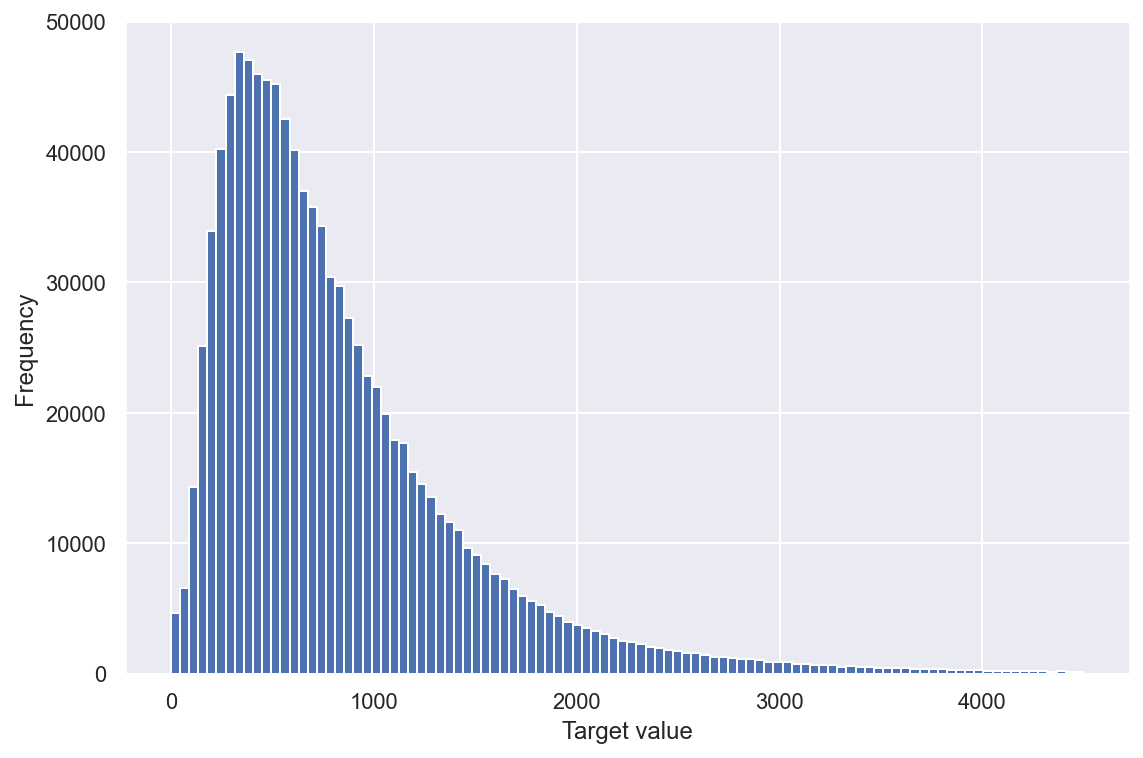

In [95]:
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 9, 6
plt.hist(list(np.expm1(y_train)), bins=100, range=(0, 4500))
plt.xlabel("Target value")
plt.ylabel("Frequency")
plt.show()

In [96]:
y_train[np.expm1(y_train) >= 3000].shape

(16563,)

In [97]:
X_train = X_train[~X_train.index.isin(X_train[np.expm1(y_train) >= 3000].index)]

In [98]:
y_train = y_train[np.expm1(y_train) < 3000]

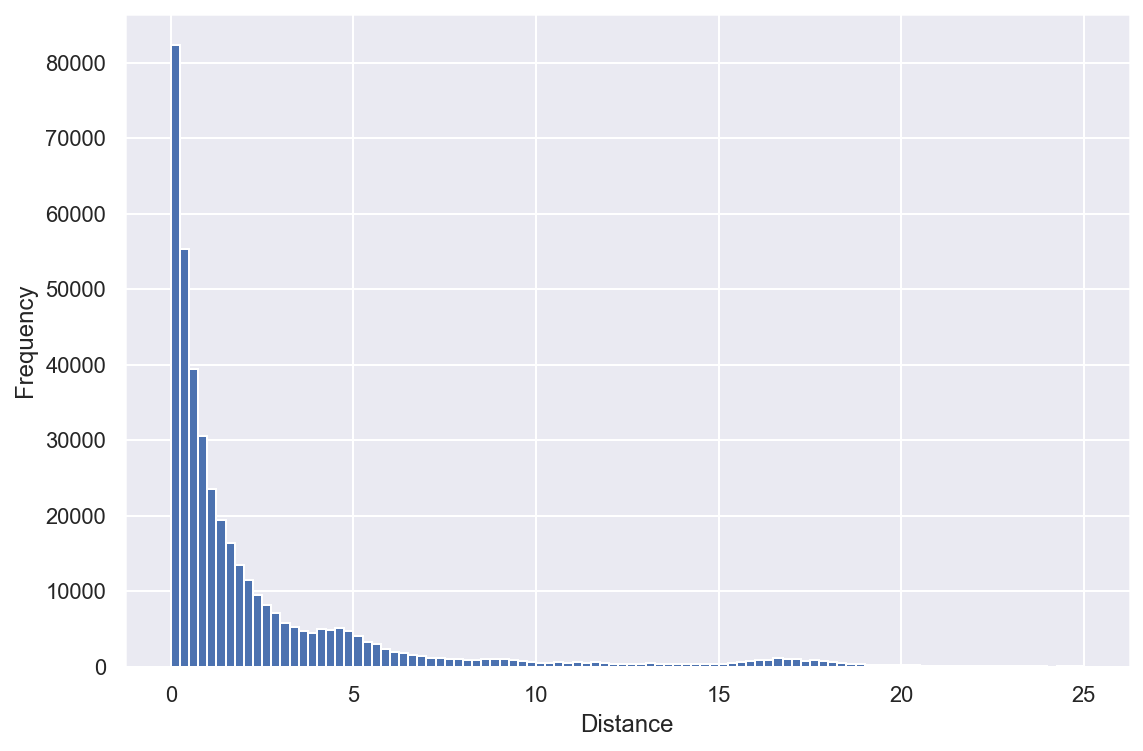

In [99]:
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 9, 6
plt.hist(list(np.expm1(X_train['log_haversine'])), bins=100, range=(0, 25))
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.show()

In [100]:
y_train = y_train[~y_train.index.isin(y_train[np.expm1(X_train['log_haversine']) >= 19].index)]

In [101]:
X_train = X_train[~X_train.index.isin(X_train[np.expm1(X_train['log_haversine']) >= 19].index)]

Поскольку некоторые признаки были выкинуты, надо обучить модель заново:

In [106]:
clf = Ridge()
clf.fit(X_train, y_train)
y_train_predicted = clf.predict(X_train)

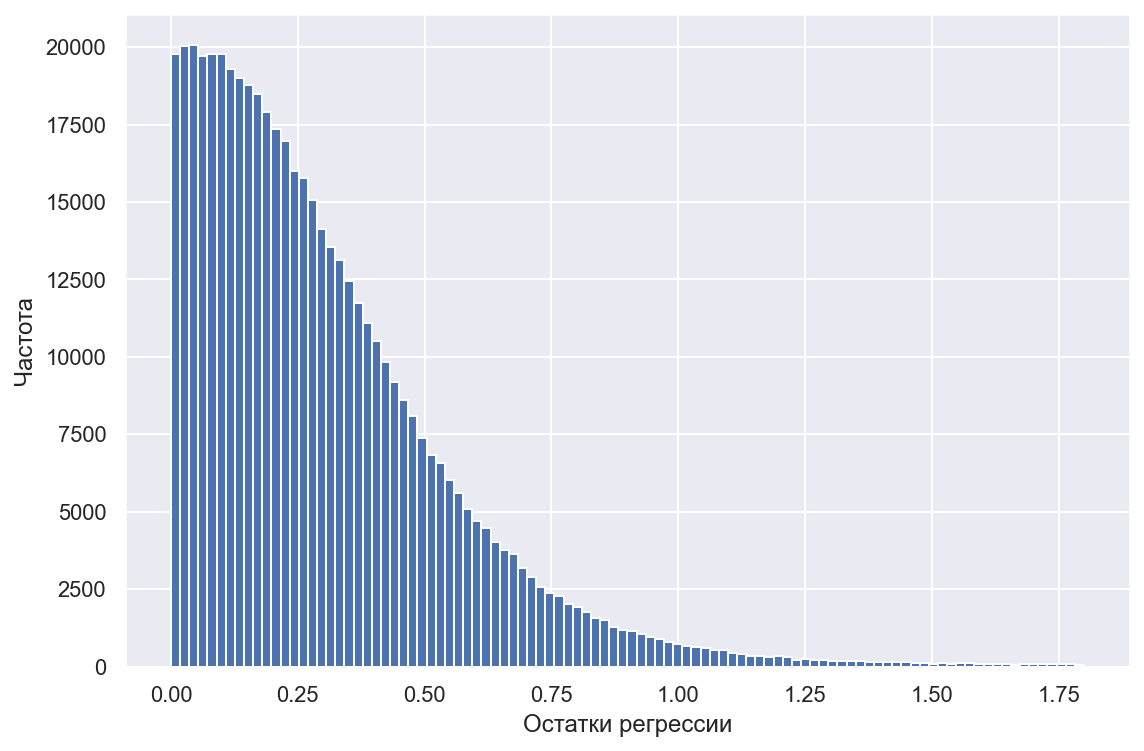

In [107]:
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 9, 6
plt.hist(list(y_train - y_train_predicted), bins=100, range=(0, 1.8))
plt.xlabel("Остатки регрессии")
plt.ylabel("Частота")
plt.show()

In [109]:
X_train = X_train[y_train - y_train_predicted <= 1]
y_train = y_train[y_train - y_train_predicted <= 1]

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Попробуйте объединить редкие категории в одну. Естественно, делать это нужно только для действительно редких категорий.

In [110]:
def count_feature_frequency(feature):
    return X_train[X_train[feature] == 1][feature].value_counts().values[0]

vcount_feature_frequency = np.vectorize(count_feature_frequency)
columns = np.array(X_train.columns)
columns = columns[columns != 'log_haversine']
counts = vcount_feature_frequency(columns)

In [111]:
columns[counts.argsort()[:30]]

array(['pickup_area_8', 'dropoff_area_8', 'pickup_day_of_year_23',
       'pickup_area_3', 'pickup_day_of_year_24', 'pickup_area_7',
       'is_snow', 'pickup_area_2', 'pickup_day_of_year_151',
       'is_memorial_day', 'pickup_day_of_year_25', 'dropoff_area_7',
       'pickup_day_of_year_3', 'pickup_day_of_year_150',
       'pickup_day_of_year_2', 'pickup_day_of_year_4',
       'pickup_day_of_year_26', 'pickup_day_of_year_172',
       'pickup_day_of_year_149', 'pickup_day_of_year_171',
       'pickup_day_of_year_178', 'pickup_day_of_year_116',
       'pickup_day_of_year_32', 'pickup_day_of_year_152',
       'pickup_day_of_year_164', 'pickup_day_of_year_165',
       'pickup_day_of_year_1', 'pickup_day_of_year_18',
       'pickup_day_of_year_179', 'pickup_day_of_year_53'], dtype=object)

Отчетливо видно, что в число категорий, которые являются редкими, входят
1. 8-я зона - она точно не является популярной, можно объединить в один признак - "посадка или высадка в 8й зоне";
2. еще редкие категории - аномальные дни (это снегопад и memorial day), но они занимают всего лишь два признака и имеют разные показатели (в снегопад поездок мало + они очень длинные, а 30-го мая поездок мало, но они достаточно короткие, тк машин на дорогах в принципе мало из-за праздника), так что объединять в один их наверное не стоит;
3. самое яркое, что бросается в глаза - это дни в году - их слишком много, порядка 180, они занимают огромное количество признаков, являясь при этом достаточно редкими категориями, так что лучше объединить их в временные промежутки по несколько дней

In [113]:
# максимальное значение дня в году
max(train['pickup_day_of_year'].values)

182

Чтобы сократить количество признаков, вместо дней возьмем недели

In [114]:
col_days_todrop = [f'pickup_day_of_year_{i}' for i in range(1, 183)]

In [115]:
def reduce_days(X):
    i = 1
    while i <= 182:
        j = min(i + 6, 182)
        X[f'pickup_day_of_year_{i}_{j}'] = X[col_days_todrop[i-1:j+1]].sum(axis=1)
        i += 7
    return X.drop(columns=col_days_todrop)


X_train = reduce_days(X_train)
X_test = reduce_days(X_test)

/Users/katyona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

In [116]:
clf = Ridge()
clf.fit(X_train, y_train)

Ridge()

In [117]:
y_predict = clf.predict(X_test)
mean_squared_error(y_predict, y_test)

0.22993602101909333

Ошибка немного выросла

**Задание 14 (1 балл)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

Не будем считать следующие признаки из оригинального датасета: 
* `id`, 
* признаки координат, 
* `haversine`, 
* `log_trip_duration`, 
* `store_and_fwd_flag`,
* `passenger_count`,
* `vendor_id`.

то есть минус 10 признаков

In [119]:
len(df.columns) - 10

6

В тренировочной выборке используются только те признаки, которые мы сами заранее выбрали, поэтому не будем ничего вычитать

In [120]:
len(X_train.columns)

98

Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

In [121]:
clf = Lasso()
clf.fit(X_train, y_train)

y_predict = clf.predict(X_test)
mean_squared_error(y_predict, y_test)

0.6340335628630769

Судя по значениям метрики, `Ridge`-регрессия все-таки лучше

Разбейте обучающую выборку на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

In [122]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=101)

In [190]:
alphas = np.arange(0.001, 0.05, 0.005)
mses_lasso = []
zeros_lasso = []
for alpha in alphas: 
    clf_lasso = Lasso(alpha=alpha)
    clf_lasso.fit(X_train, y_train)
    zeros_lasso.append(clf_lasso.coef_.shape[0] - np.count_nonzero(clf_lasso.coef_))
    mses_lasso.append(mean_squared_error(clf_lasso.predict(X_val), y_val))

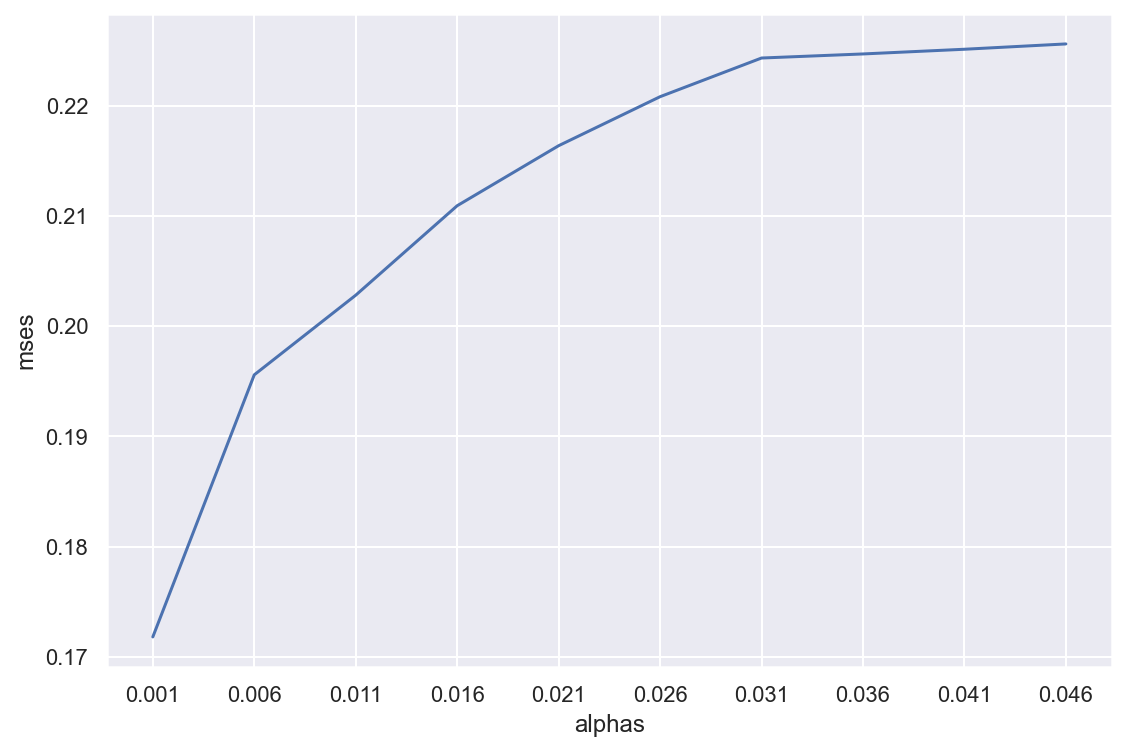

In [192]:
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = 9, 6
plt.plot(alphas, mses_lasso)
plt.xticks(alphas[::])
plt.xlabel("alphas")
plt.ylabel("mses")
plt.show()

In [179]:
clf_ = Lasso(alpha=0.001)
clf_.fit(X_train, y_train)
mean_squared_error(clf_.predict(X_test), y_test)

0.23167340417161134

In [181]:
alphas_r = np.arange(1, 2, 0.05)
mses_ridge = []
zeros_ridge = []
for alpha in alphas_r: 
    clf_ridge = Ridge(alpha=alpha)
    clf_ridge.fit(X_train, y_train)
    zeros_ridge.append(clf_ridge.coef_.shape[0] - np.count_nonzero(clf_ridge.coef_))
    mses_ridge.append(mean_squared_error(clf_ridge.predict(X_val), y_val))

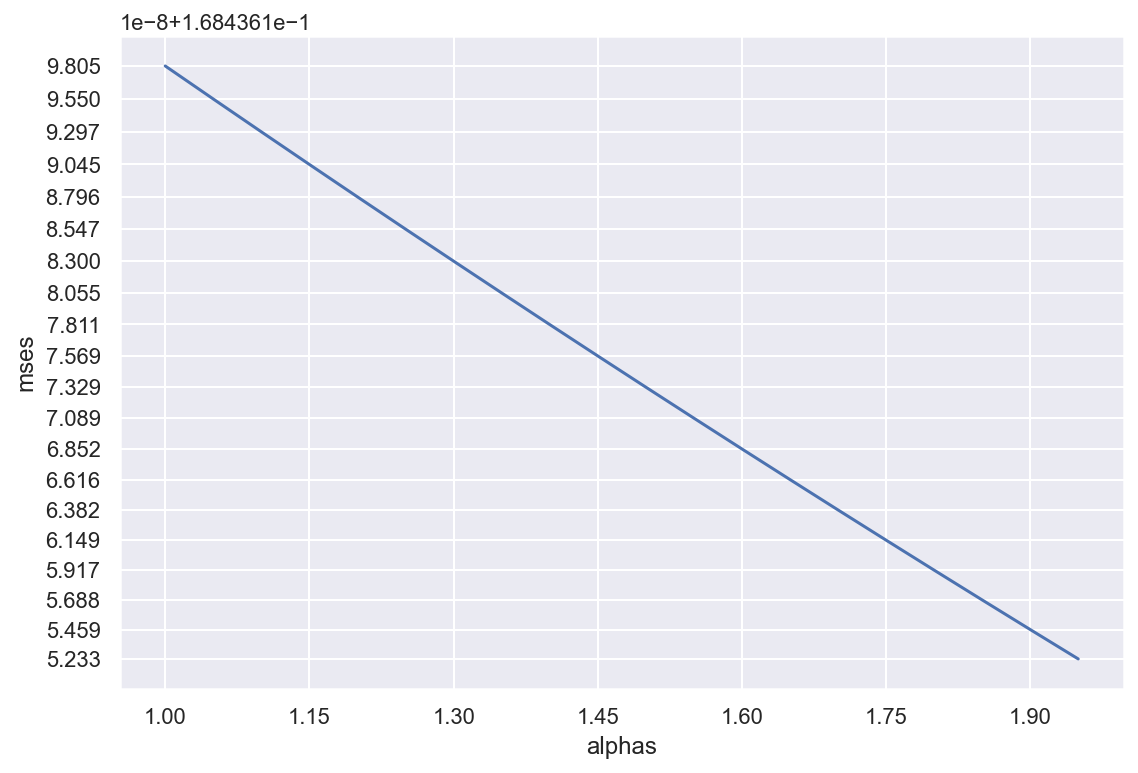

In [182]:
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = 9, 6
plt.plot(alphas_r, mses_ridge)
plt.xticks(alphas_r[::3])
plt.yticks(mses_ridge)
plt.xlabel("alphas")
plt.ylabel("mses")
plt.show()

In [183]:
clf_ridge = Ridge(alpha=2)
clf_ridge.fit(X_train, y_train)
mean_squared_error(clf_.predict(X_test), y_test)

0.23167340417161134

Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

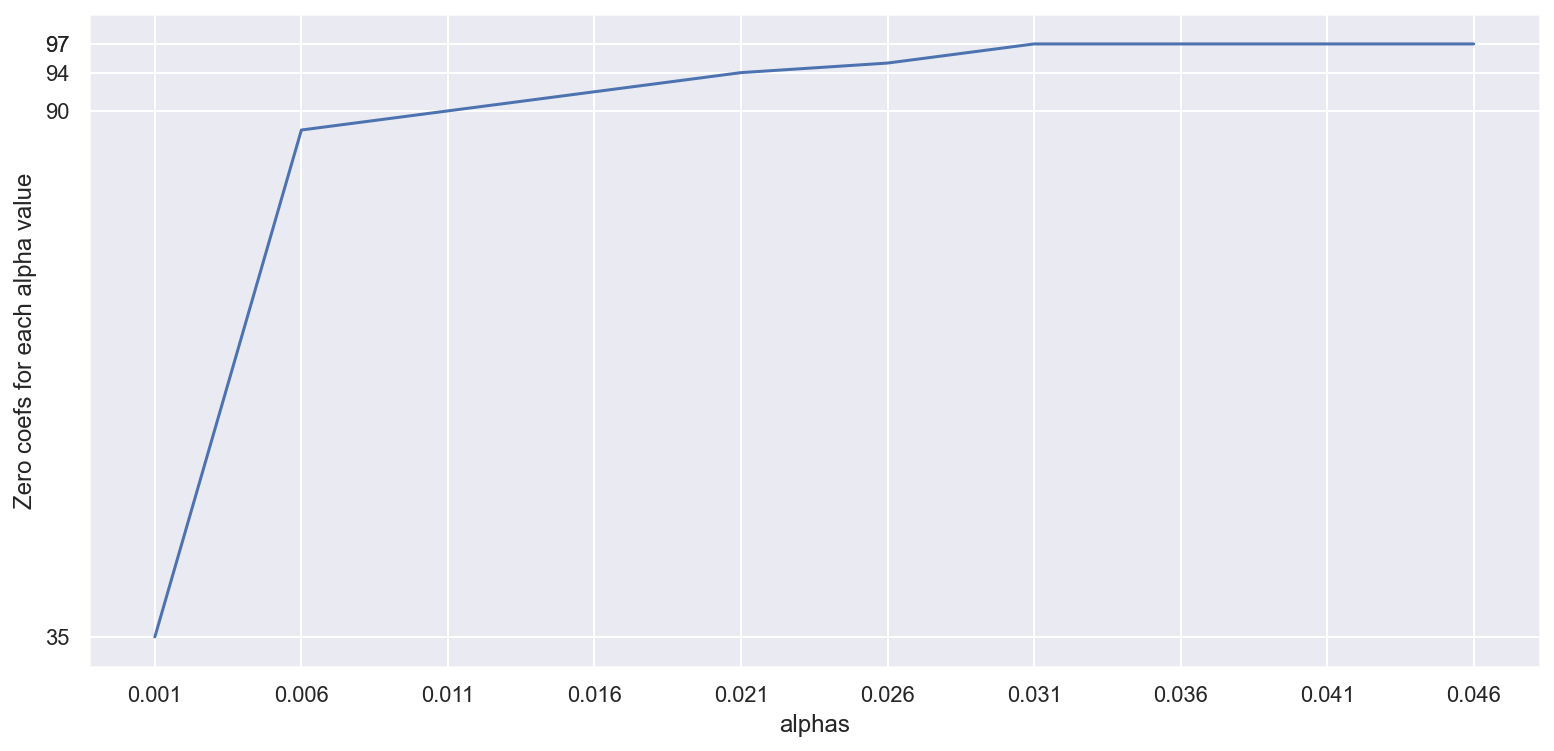

In [194]:
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = 13, 6
plt.plot(alphas, zeros_lasso)
plt.xticks(alphas[::])
plt.yticks(zeros_lasso[::2])
plt.xlabel("alphas")
plt.ylabel("Zero coefs for each alpha value")
plt.show()

Чем ниже альфа, тем меньше весов зануляется, причем при небольшом увеличении альфа зануляется сразу очень много весов. Если мы хотим избавиться хотя бы от половины признаков, то мы не сильно потеряем в качетве, тк коэффициент регуляризации будет не сильно выше отпимального ввыбранного.

<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15 (1 балл)**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

Также можете придумать ещё какой-нибудь способ сделать признаки про маршрут. Если эти признаки будут давать хороший прирост в качестве, то за это могут быть даны дополнительные бонусные баллы.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

In [209]:
top100 = train[['pickup_area', 'dropoff_area']].value_counts().nlargest(100).to_frame().reset_index()
top100['target_name'] = top100.apply(lambda row: f"{row['pickup_area']}_{row['dropoff_area']}", axis=1)

In [278]:
popular_routes = top100[['pickup_area', 'dropoff_area']].values.tolist()

def route_popular(arr):
    if arr.tolist() in popular_routes:
        return f'{arr[0]}_{arr[1]}'
    else:
        return -1

    
# train['popular_route'] = np.apply_along_axis(route_popular, 1, train[['pickup_area', 'dropoff_area']].values)
sample = train.sample(10)
np.apply_along_axis(route_popular, 1, sample[['pickup_area', 'dropoff_area']].values)

[10, 9]
10_9
[10, 10]
10_10
[5, 1]
5_1
[4, 1]
4_1
[6, 0]
6_0
[6, 10]
6_10
[6, -1]
6_-1
[10, 10]
10_10
[5, -1]
5_-1
[0, -1]
0_-1


array(['10_9', '10_1', '5_1', '4_1', '6_0', '6_10', '6_-1', '10_1',
       '5_-1', '0_-1'], dtype='<U4')

In [290]:
[-10, -1] in popular_routes

False

In [265]:
sample[['pickup_area', 'dropoff_area']]

,pickup_area,dropoff_area
577418,5,4
445903,5,5
230451,6,9
72250,4,-1
578448,5,4
855835,1,1
185878,1,5
282936,4,5
1458500,4,1
730782,0,5


In [256]:
len(set(top100['target_name'].values))

100

In [195]:
X_train.groupby(['Name','Surname'])['Name'].count().argmax()

Index(['pickup_hour_0', 'pickup_hour_1', 'pickup_hour_2', 'pickup_hour_3',
       'pickup_hour_4', 'pickup_hour_5', 'pickup_hour_6', 'pickup_hour_7',
       'pickup_hour_8', 'pickup_hour_9', 'pickup_hour_10', 'pickup_hour_11',
       'pickup_hour_12', 'pickup_hour_13', 'pickup_hour_14', 'pickup_hour_15',
       'pickup_hour_16', 'pickup_hour_17', 'pickup_hour_18', 'pickup_hour_19',
       'pickup_hour_20', 'pickup_hour_21', 'pickup_hour_22', 'pickup_hour_23',
       'pickup_weekday_0', 'pickup_weekday_1', 'pickup_weekday_2',
       'pickup_weekday_3', 'pickup_weekday_4', 'pickup_weekday_5',
       'pickup_weekday_6', 'pickup_month_1', 'pickup_month_2',
       'pickup_month_3', 'pickup_month_4', 'pickup_month_5', 'pickup_month_6',
       'pickup_area_-1', 'pickup_area_0', 'pickup_area_1', 'pickup_area_2',
       'pickup_area_3', 'pickup_area_4', 'pickup_area_5', 'pickup_area_6',
       'pickup_area_7', 'pickup_area_8', 'pickup_area_9', 'pickup_area_10',
       'pickup_area_11', 'dropoff

Заново обучите модель (`Ridge`, если она дала более высокое качество в предыдущих экспериментах, и `Lasso` иначе) на новых даннных и посчитайте качество на тестовой выборке

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 16 (бонус, 1 балл)**. Где, как не для нашей задачи, считать манхэттенское расстояние?

**Вопрос**: Найдите, что такое манхэттенское расстояние и почему оно так называется. Как оно нам может помочь?

Введите систему координат на нашей карте так, чтобы оси были параллельны улицам Манхэттена, и добавьте сначала в данные признак "манхэттенское расстояние между пунктом отправления и пунктом назначения", а затем и логарифм этого признака. Посчитайте корреляцию между вашим новыми признаком и таргетом; между `log_haversine` и таргетом. В каком случае корреляция больше?

Нарисуйте карту, где покажете выбранные оси. Чтобы мы могли проверить вашу работу, просьба сделать скрин этой карты и приложить картинку (если мы откроем ваш ноутбук, виджеты отображаться не будут). 

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Заново обучите модель на новых даннных и посчитайте качество на тестовой выборке. Стало ли лучше? Объясните полученный результат.

#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 17 (бонус, 2 балла)**. Реализуйте трансформер, который строит разбиение карты по шестигранной решётке с помощью библиотеки [H3](https://github.com/uber/h3-py) и вычисляет признаки на основе такого разбиения.

Признаки могут быть самые разные: расстояние между точкой старта и финиша, посчитанное в количестве шестиугольников; статистика по числу поездок и по их продолжительности в соседних шестиугольниках.

Важно: производительность библиотеки существенно зависит от количества шестиугольников на карте (определяется параметром resolution). Подберите такое разрешение, при котором ваш код будет работать за приемлемое время.

При построении признаков старайтесь не допустить утечки целевой переменной (подробнее про это можно почитать в материалах 1-го семинара) — в противном случае хорошего качества на тестовой выборке достичь не получится.

Измерьте качество после добавления новых признаков. За улучшение функционала ошибки на каждые 0.005 на тестовой выборке будет даваться 0.5 бонусных балла. Можно получить до 2 бонусных баллов за это задание.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.

## Ссылки на источники:

* код, чтобы дни недели отражались на графике в правильном порядке, взят [отсюда](https://stackoverflow.com/questions/60336304/not-able-to-set-the-row-order-in-seaborn-relplot)
* [haversine](https://towardsdatascience.com/heres-how-to-calculate-distance-between-2-geolocations-in-python-93ecab5bbba4)
* [референс для MapGridEstimator](https://ru.stackoverflow.com/questions/1161594/%D0%A0%D0%B0%D0%B7%D0%B1%D0%B8%D0%B5%D0%BD%D0%B8%D0%B5-%D0%BE%D0%B1%D0%BB%D0%B0%D1%81%D1%82%D0%B8-%D0%BD%D0%B0-%D1%8F%D1%87%D0%B5%D0%B9%D0%BA%D0%B8-%D0%B8-%D0%BF%D1%80%D0%B8%D1%81%D0%B2%D0%BE%D0%B5%D0%BD%D0%B8%D0%B5-%D0%BC%D0%B5%D1%82%D0%BE%D0%BA-%D1%81-%D0%BD%D0%B0%D1%87%D0%B0%D0%BB%D0%BE%D0%BC-%D0%B8-%D0%BA%D0%BE%D0%BD%D1%86%D0%BE%D0%BC)